In [4]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import glob
from scipy.stats.mstats import gmean

In [5]:
path_float_data = "./"
mem_values = [512, 2048, 4096, 8192, 10240]
mem_values_short = [512, 2048, 4096, 8192]
aws_threads = [2, 2, 3, 5, 6]
ow_threads = [2, 2, 3, 5, 6]
gcr_threads = [2, 4, 4, 4, 0]
gcf_threads = [2, 2, 2, 2, 0]
functions = ["Atax_Mean"]
languages = ['java', 'golang', 'c++']
services = ['aws', 'ow', 'gcr', 'google', 'vm']


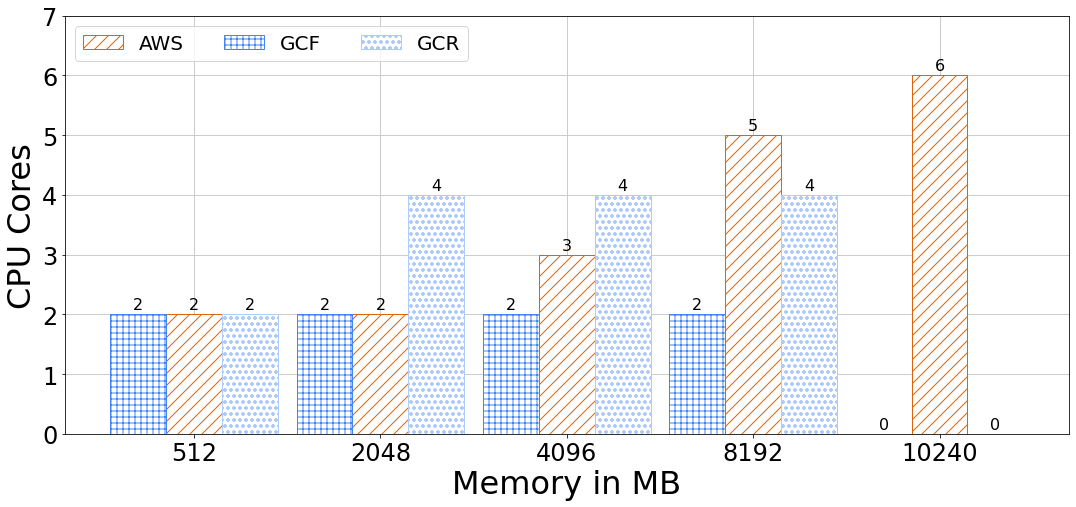

In [714]:
from matplotlib import rc, rcParams
rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(15,7))

x = np.arange(len(mem_values))
x_2 = np.arange(len(mem_values_short))
width = 0.3

threads_aws = ax.bar(x + width * 0, aws_threads, width, label='AWS', ecolor='#d9660b', edgecolor='#d9660b', color='w', hatch='//')
# threads_ow = ax.bar(x - width * 0.5, ow_threads, width, label='OW', color='#008571', hatch='xx')
threads_gcf = ax.bar(x - width * 1, gcf_threads, width, label='GCF', ecolor='#4286f5', edgecolor='#4286f5', color='w', hatch='++')
threads_gcr = ax.bar(x + width * 1, gcr_threads, width, label='GCR', ecolor='#aecbfa', edgecolor='#aecbfa', color='w', hatch='oo')

ax.set_ylabel('CPU Cores', size=32.0)
ax.set_xlabel('Memory in MB', size=32.0)
#ax.set_title('Available Threads per service by Memory Configuration')
ax.set_xticks(x)
ax.set_xticklabels(mem_values)
ax.legend(prop={'size': 20}, loc='upper left', ncol=3)

ax.bar_label(threads_aws, padding=2, size=16)
ax.bar_label(threads_gcf, padding=2, size=16)
ax.bar_label(threads_gcr, padding=2, size=16)
ax.set_ylim([0, 7])
fig.tight_layout()
ax.tick_params(axis='both', labelsize = 24.0)
ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
ax.set_axisbelow(True)
fig.savefig("Graphs/Threads.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
plt.show()


In [225]:
def concat_df(list_files):
    list_dfs = []
    for filename in list_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        list_dfs.append(df)
    df = pd.concat(list_dfs, axis=0, ignore_index=True)
    df = df.replace("undefined", None)
    df= df.dropna()
    return df

concatenated_df_list = []

for function in functions:
    function_file= [f for f in glob.glob(path_float_data + function + ".csv", recursive=True)]
    df = concat_df(function_file)
    df["Functionname"] = function
    concatenated_df_list.append(df)


In [226]:
def closestNumber(n, m) :
    # Find the quotient
    q = int(n / m)
      
    # 1st possible closest number
    n1 = m * q
      
    # 2nd possible closest number
    if((n * m) > 0) :
        n2 = (m * (q + 1)) 
    else :
        n2 = (m * (q - 1))
      
    # if true, then n1 is the required closest number
#     if (abs(n - n1) < abs(n - n2)) :
#         return n1
      
    # else n2 is the required closest number 
    return n2

In [227]:
def calculate_costs_aws(list_execution_times, offset=0):
    cost_per_mil = 0.20
    per_mil = 1000000
    list_cost = []
    price_per_ms = [0.0000000083, 0.0000000333, 0.0000000667, 0.0000001333, 0.0000001667]
    for i in range(len(list_execution_times)):
        cost_val = per_mil * list_execution_times[i] * price_per_ms[i + offset] + cost_per_mil
        list_cost.append(cost_val)
    
    return list_cost


def calculate_costs_gcf(list_execution_times, offset=0):
#     print(list_execution_times)
    #list_execution_times_ms = list_execution_times*1000
#     print(list_execution_times_ms)
    mem_list = [512, 2048, 4096, 8192]
    compute_list = [800, 2400, 4800, 4800]
    GB_ms_cost_tier_1 = 0.0000025 / 1000
    GHz_ms_cost_tier_1 = 0.0000100 / 1000
    per_mil = 1000000
    cost_per_mil = 0.40
    list_cost = []
    for i in range(len(list_execution_times)):
#         print(closestNumber(int(list_execution_times_ms[i]), 100))
        time = closestNumber(int(list_execution_times[i]), 100)
        #time = list_execution_times[i]
        gb_s = (mem_list[i + offset]/1024)*time*per_mil*GB_ms_cost_tier_1
#         print(gb_s)
        gh_s = (compute_list[i + offset]/1000)*time*per_mil*GHz_ms_cost_tier_1
#         print(gh_s)
        cost_val = gb_s+gh_s+cost_per_mil
#         print(cost_val)
        list_cost.append(cost_val)
    return list_cost


def calculate_costs_gcr(list_execution_times, offset=0):
    mem_list = [512, 2048, 4096, 8192]
    CPU_list = [2, 4, 4, 4]
    vCPU_ms_cost_tier_1 = 0.00002400 / 1000
    GB_ms_cost_tier_1 = 0.00000250 / 1000
    per_mil = 1000000
    cost_per_mil = 0.40
    list_cost = []
    for i in range(len(list_execution_times)):
        time = closestNumber(int(list_execution_times[i]), 100)
        #time = list_execution_times[i]
        gb_s = (mem_list[i + offset]/1024)*time*per_mil*GB_ms_cost_tier_1
        cpu_s = CPU_list[i + offset]*time*per_mil*vCPU_ms_cost_tier_1
        cost_val = gb_s+cpu_s+cost_per_mil
        list_cost.append(cost_val)
    return list_cost
        

print(calculate_costs_gcf([1, 1, 1, 1]))
print(calculate_costs_aws([100, 100, 100, 100, 1000]))
print(calculate_costs_gcr([512, 340, 1, 1]))

[1.3250000000000002, 3.3, 6.2, 7.2]
[1.03, 3.5300000000000002, 6.87, 13.53, 166.9]
[29.95, 40.8, 11.0, 12.0]


In [228]:
def calculate_costs_series_aws(list_execution_times, memory):
    cost_per_mil = 0.20
    per_mil = 1000000
    list_cost = []
    index = mem_values.index(memory)
    price_per_ms = [0.0000000083, 0.0000000333, 0.0000000667, 0.0000001333, 0.0000001667]
    for i in range(len(list_execution_times)):
        cost_val = per_mil * list_execution_times[i] * price_per_ms[index] + cost_per_mil
        list_cost.append(cost_val)
    
    return list_cost


def calculate_costs_series_gcf(list_execution_times, memory):
#     print(list_execution_times)
    #list_execution_times_ms = list_execution_times*1000
#     print(list_execution_times_ms)
    mem_list = mem_values_short
    index = mem_list.index(memory)
    compute_list = [800, 2400, 4800, 4800]
    GB_ms_cost_tier_1 = 0.0000025 / 1000
    GHz_ms_cost_tier_1 = 0.0000100 / 1000
    per_mil = 1000000
    cost_per_mil = 0.40
    list_cost = []
    for i in range(len(list_execution_times)):
#         print(closestNumber(int(list_execution_times_ms[i]), 100))
        time = closestNumber(int(list_execution_times[i]), 100)
        #time = list_execution_times[i]
        gb_s = (mem_list[index]/1024)*time*per_mil*GB_ms_cost_tier_1
#         print(gb_s)
        gh_s = (compute_list[index]/1000)*time*per_mil*GHz_ms_cost_tier_1
#         print(gh_s)
        cost_val = gb_s+gh_s+cost_per_mil
#         print(cost_val)
        list_cost.append(cost_val)
    return list_cost


def calculate_costs_series_gcr(list_execution_times, memory):
    mem_list = mem_values_short
    index = mem_list.index(memory)
    CPU_list = [2, 4, 4, 4]
    vCPU_ms_cost_tier_1 = 0.00002400 / 1000
    GB_ms_cost_tier_1 = 0.00000250 / 1000
    per_mil = 1000000
    cost_per_mil = 0.40
    list_cost = []
    for i in range(len(list_execution_times)):
        time = closestNumber(int(list_execution_times[i]), 100)
        #time = list_execution_times[i]
        gb_s = (mem_list[index]/1024)*time*per_mil*GB_ms_cost_tier_1
        cpu_s = CPU_list[index]*time*per_mil*vCPU_ms_cost_tier_1
        cost_val = gb_s+cpu_s+cost_per_mil
        list_cost.append(cost_val)
    return list_cost
        

print(calculate_costs_series_gcf([1, 1, 1, 1], 512))
print(calculate_costs_series_aws([100, 100, 100, 100, 100], 512))
print(calculate_costs_series_gcr([1, 1, 1, 1], 512))

[1.3250000000000002, 1.3250000000000002, 1.3250000000000002, 1.3250000000000002]
[1.03, 1.03, 1.03, 1.03, 1.03]
[5.325, 5.325, 5.325, 5.325]


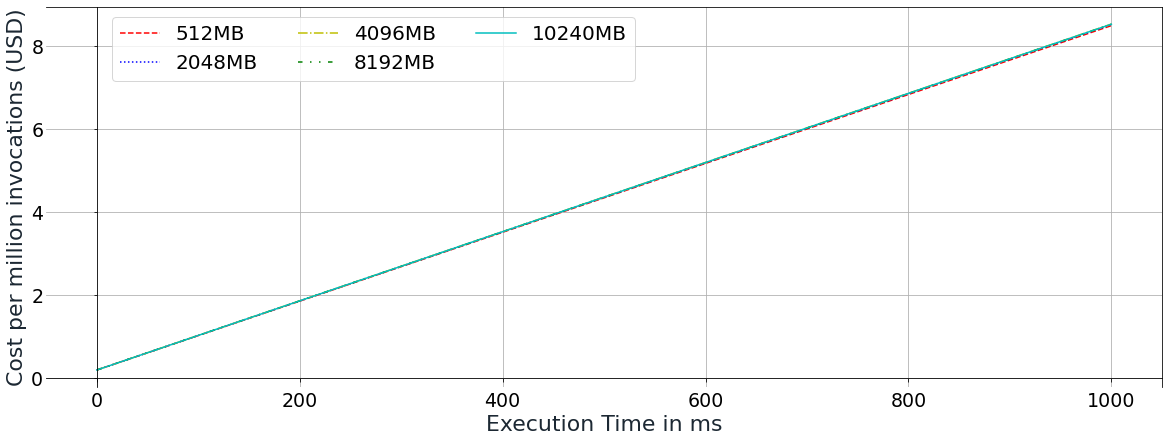

In [234]:
# Cost function graphs
# AWS
x = np.linspace(0,1000,5)

y_512 = 1000000 * x * 0.0000000083 + 0.2
y_2048 = 1000000 * (x / 4) * 0.0000000333 + 0.2
y_4096 = 1000000 * (x / 8 ) * 0.0000000667 + 0.2
y_8192 = 1000000 * (x/ 16 ) * 0.0000001333 + 0.2
y_10240 = 1000000 * (x /20) * 0.0000001667 + 0.2

fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')

ax.tick_params(axis='both', pad=10, labelsize = 19.0)
ax.tick_params(axis='y', pad=50, labelsize = 19.0)
# plot the function
plt.plot(x,y_512, 'r', label="512MB", linestyle="dashed")
plt.plot(x,y_2048, 'b', label="2048MB",linestyle="dotted")
plt.plot(x,y_4096, 'y', label="4096MB", linestyle="dashdot")
plt.plot(x,y_8192, 'g', label="8192MB", linestyle= (0, (3, 5, 1, 5, 1, 5)))
plt.plot(x,y_10240, 'c', label="10240MB", linestyle="solid")
plt.xlabel('Execution Time in ms', color='#1C2833', size=22.0)
plt.ylabel('Cost per million invocations (USD)', color='#1C2833', size=22.0)

plt.legend(loc='upper left',  bbox_to_anchor=(0.05, 1), prop={'size': 20}, ncol=3)
plt.grid()
fig.savefig("Graphs/Lin_Funcs/Cost_Graph_AWS_par_speed.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

# show the plot
plt.show()

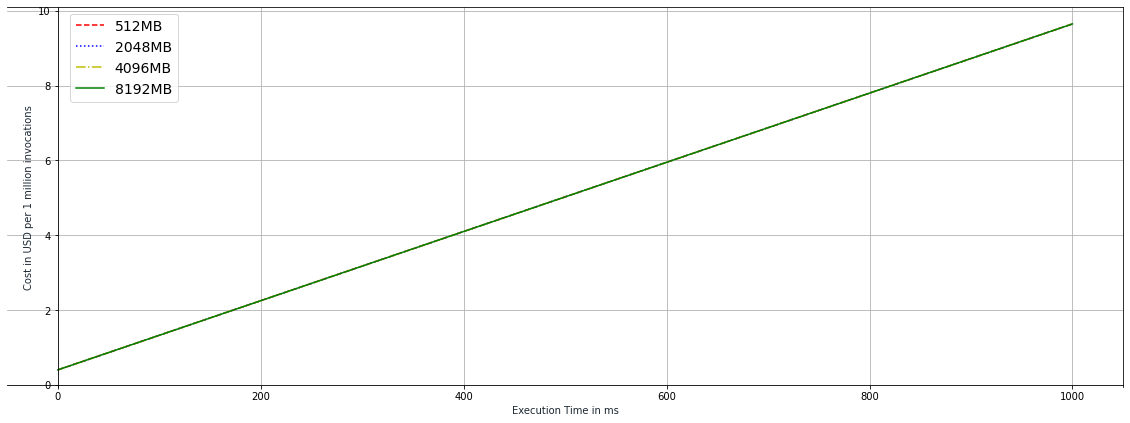

In [12]:
# Cost function graphs
# GCF
GB_ms = 0.0000025 / 1000
GHz_ms = 0.0000100 / 1000
x = np.linspace(0,1000,5)
y_512 = (1000000 * (x / 1) * (512/1024) * GB_ms) + (GHz_ms * (800/1000) * (x / 1) * 1000000) + 0.4
y_2048 = (1000000 * (x / 3.135) * (2048/1024) * GB_ms) + (GHz_ms * (2400/1000) * (x / 3.135) * 1000000) + 0.4
y_4096 = (1000000 * (x / 6.27) * (4096/1024) * GB_ms) + (GHz_ms * (4800/1000) * (x / 6.27) * 1000000) + 0.4
y_8192 = (1000000 * (x / 7.351) * (8192/1024) * GB_ms) + (GHz_ms * (4800/1000) * (x / 7.351) * 1000000) + 0.4


fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')


# plot the function
plt.plot(x,y_512, 'r', label="512MB", linestyle="dashed")
plt.plot(x,y_2048, 'b', label="2048MB",linestyle="dotted")
plt.plot(x,y_4096, 'y', label="4096MB", linestyle="dashdot")
plt.plot(x,y_8192, 'g', label="8192MB", linestyle="solid")
plt.xlabel('Execution Time in ms', color='#1C2833')
plt.ylabel('Cost in USD per 1 million invocations', color='#1C2833')
plt.legend(loc='upper left',  bbox_to_anchor=(0.05, 1), prop={'size': 14})
plt.grid()
fig.savefig("Graphs/Cost_Graph_GCF_par_speedup.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

# show the plot
plt.show()

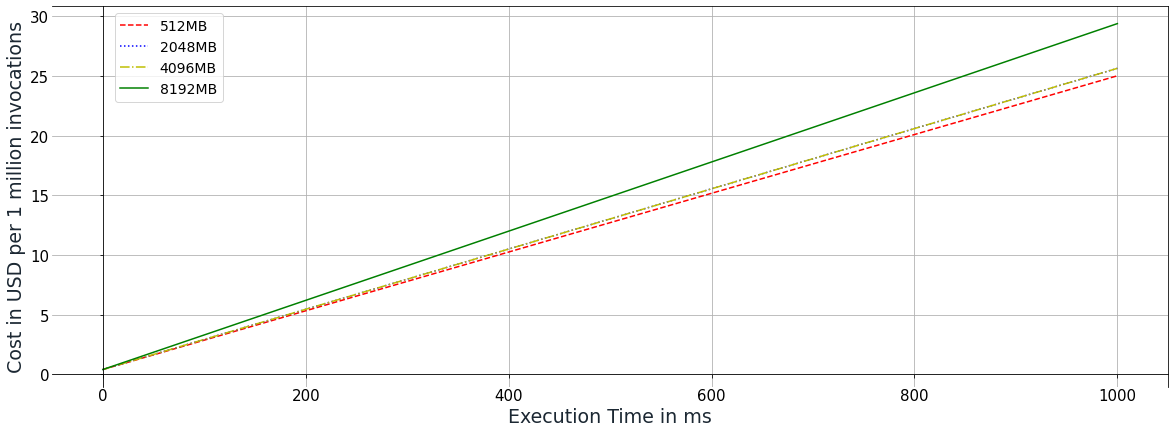

In [13]:
# Cost function graphs
# GCR
vCPU_ms = 0.00002400 / 1000
GB_ms = 0.00000250 / 1000
x = np.linspace(0,1000,5)
y_512 = (1000000 * (x / 2)  * (512/1024) * GB_ms) + (vCPU_ms * 2 * (x / 2) * 1000000) + 0.4
y_2048 = (1000000 * (x / 4) * (2048/1024) * GB_ms) + (vCPU_ms * 4 * (x / 4) * 1000000) + 0.4
y_4096 = (1000000 * (x / 4) * (2048/1024) * GB_ms) + (vCPU_ms * 4 * (x / 4) * 1000000) + 0.4
y_8192 = (1000000 * (x / 4) * (8192/1024) * GB_ms) + (vCPU_ms * 4 * (x / 4) * 1000000) + 0.4


fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1, 1, 1)

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.tick_params(axis='both', pad=10, labelsize = 15.0)
ax.tick_params(axis='y', pad=50, labelsize = 15.0)

# plot the function
plt.plot(x,y_512, 'r', label="512MB", linestyle="dashed")
plt.plot(x,y_2048, 'b', label="2048MB",linestyle="dotted")
plt.plot(x,y_4096, 'y', label="4096MB", linestyle="dashdot")
plt.plot(x,y_8192, 'g', label="8192MB", linestyle="solid")
plt.xlabel('Execution Time in ms', color='#1C2833', size=19.0)
plt.ylabel('Cost in USD per 1 million invocations', color='#1C2833', size=19.0)
plt.legend(loc='upper left',  bbox_to_anchor=(0.05, 1), prop={'size': 14})
plt.grid()
fig.savefig("Graphs/Cost_Graph_GCR_par_speedup.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

# show the plot
plt.show()

In [21]:
from pylab import setp
def setBoxColors(bp, l):
    if(l == 'c++'):
        col = 'red'
    if(l == 'java'):
        col = 'blue'
    if(l == 'golang'):
        col = 'yellow'
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=2)
        # change fill color
        box.set( facecolor = 'white' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='black', linestyle='--', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color=col, linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='black', alpha=0.5)

In [26]:
# Import All sorted
# df_all = pd.read_csv('All_Sorted.csv', index_col=None, header=0)
df_all = pd.read_csv('Commercial_All.csv', index_col=None, header=0)
df_all_exec = pd.read_csv('All_Sorted_Exec.csv', index_col=None, header=0)

In [433]:
# Select Input, Function
func = "heat"
inp = "M"
df_f = df_all[(df_all['Benchmark'] == func) & (df_all['Input'] == inp)]
#df_f = df_all_exec[(df_all_exec['Benchmark'] == func) & (df_all_exec['Input'] == inp)]
languages = ["java", "golang", "c++"]

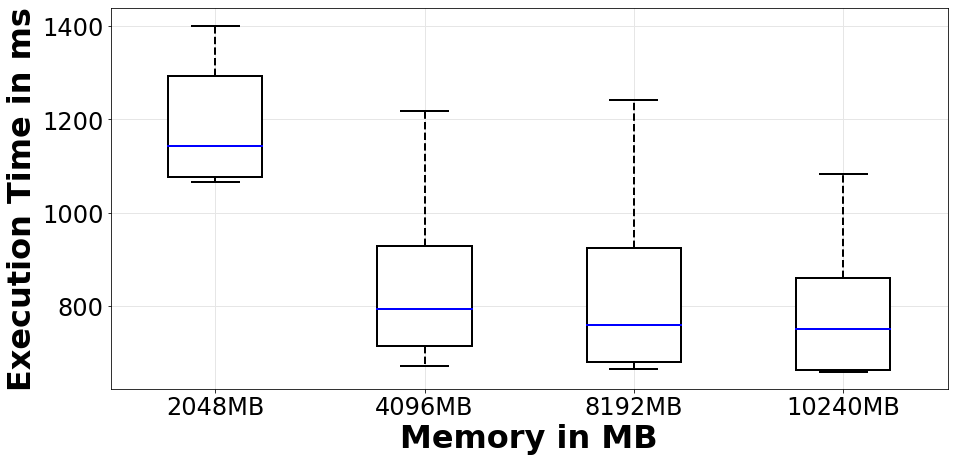

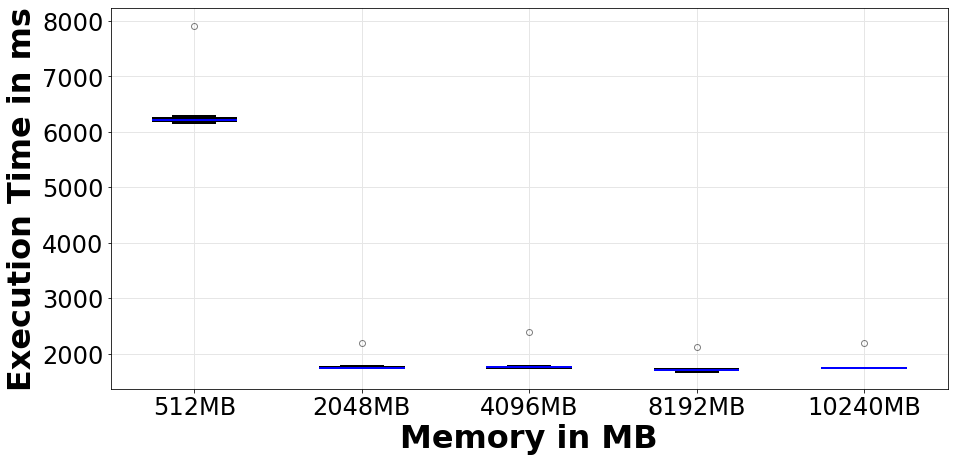

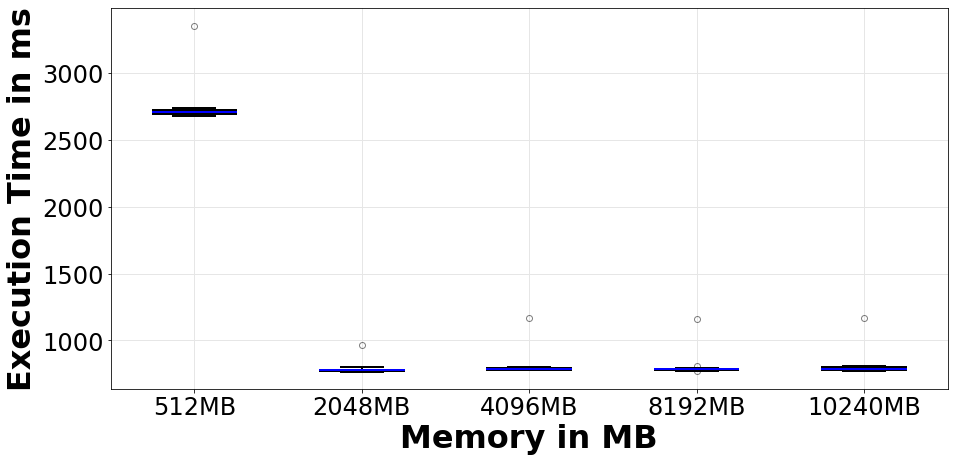

In [434]:
df_m = df_f[(df_f['Threads'] == 1)]
df_m = df_m.sort_values(by=['Memory'])

for l in languages:
    if l == ("python"):
        continue
    tick_label_list = []
    series_list = []
    for s in services:
        if(s != 'aws'):
            continue
        for m in mem_values:
            df_series = df_m[(df_m['Service'] == s) & (df_m['Language'] == l) & (df_m['Memory'] == m)]
            if ((s == 'google' or s == 'gcr') and m == 10240):
                continue
            if df_series.empty:
                continue
            series_list.append(np.asarray(df_series['_value']))
            if(s == 'aws'):
                s_name = 'AWS'
            if(s == 'google'):
                s_name = 'GCF'
            if(s == 'gcr'):
                s_name = 'GCR'
            if(l == 'java'):
                l_name = 'Java'
            if(l == 'golang'):
                l_name = 'Go'
            if(l == 'c++'):
                l_name = 'C++'
            if(func == 'mvt'):
                func_name = 'MVT'
            else:
                func_name = func.capitalize()
            
            
            # name = func_name + "_" + s_name + "_" + l_name + "_" + str(m) + "MB"
            # name = l_name + "_" + s_name + "_" + str(m) + "MB"
            name = str(m) + 'MB'
            tick_label_list.append(name)
    fig = plt.figure(1, figsize=(15, 7))
    rcParams['figure.figsize'] = 12, 6
    rcParams['axes.labelsize'] = 14
    rcParams['axes.titlesize'] = 20
    rcParams["font.size"] = 12
    positions = []
    
    # Dont ask im too stupid to do this right
    for i in range(len(tick_label_list)):
        positions.insert(0, 0)
    for i in range(len(positions)):
        positions[i] = i
    ax = fig.add_subplot(111)
    bp = ax.boxplot(series_list, positions=positions, patch_artist=True)
    setBoxColors(bp, 'java')  
    ax.set_ylabel('Execution Time in ms', size=32.0, weight='bold')
    ax.set_xlabel('Memory in MB', size=32.0, weight='bold')
    x_s = np.arange(len(tick_label_list))
    ax.set_xticks(x_s)
    # ax.set_xticklabels(tick_label_list, rotation=90)
    ax.set_xticklabels(tick_label_list)
    ax.tick_params(axis='both', labelsize = 24.0)
    ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)


    fig.savefig("Graphs/MotivationExample/Exec_Seq_" + func_name + "_" + l + ".pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
    plt.show()
        

aws


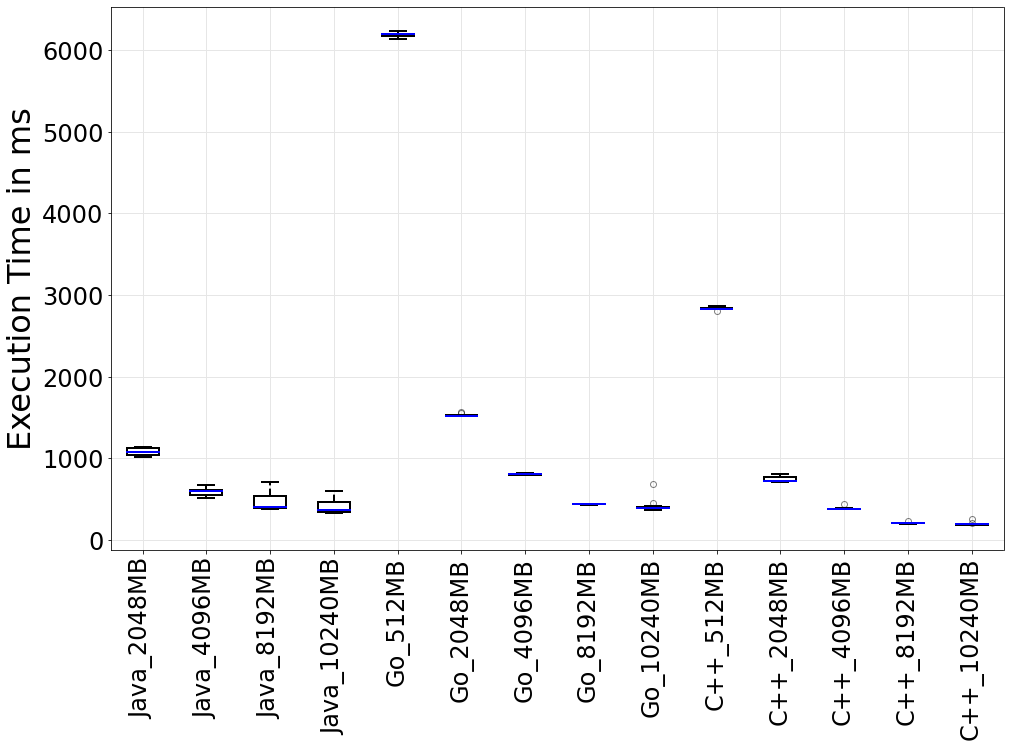

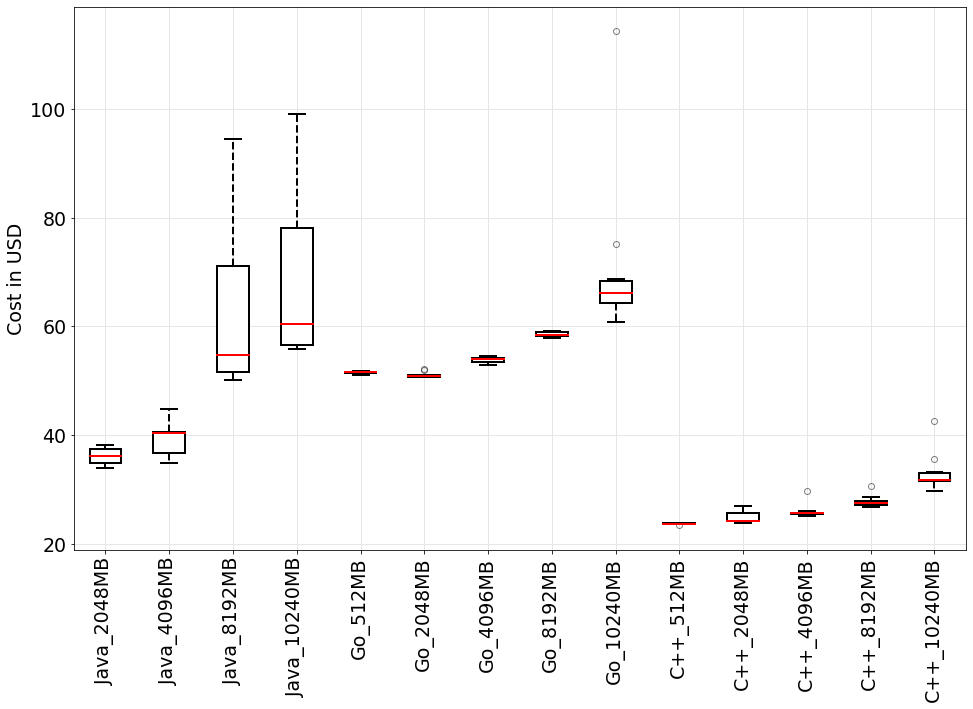

ow
gcr


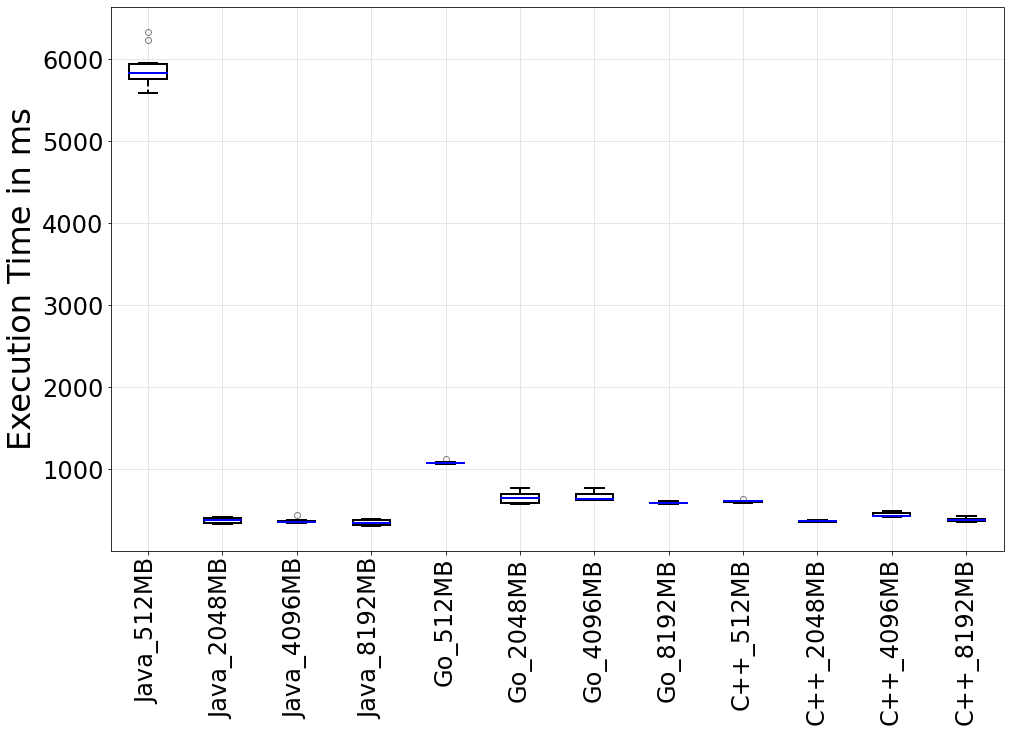

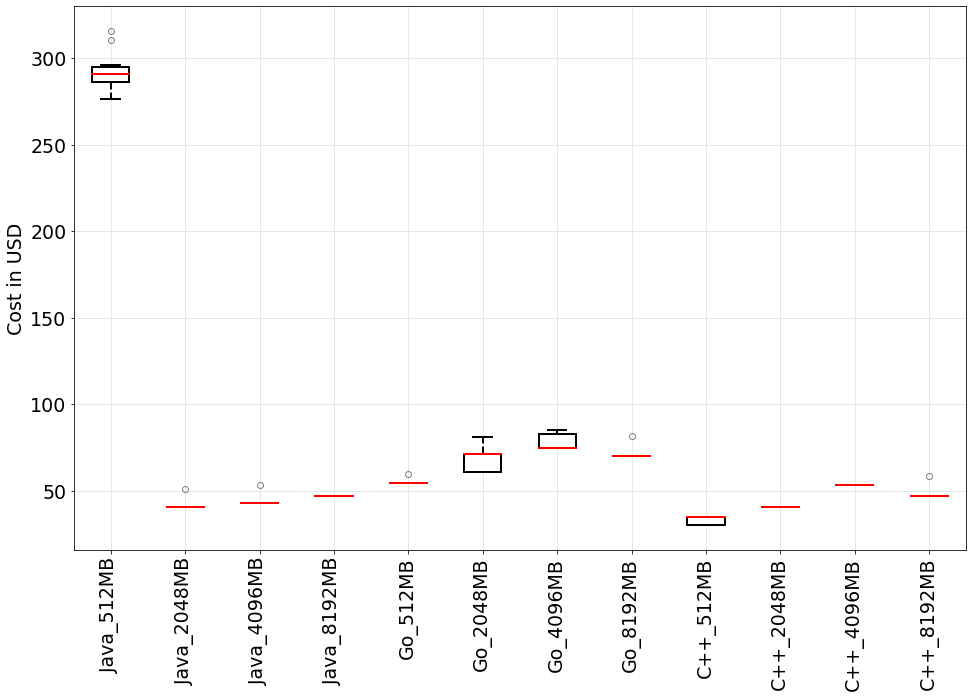

google


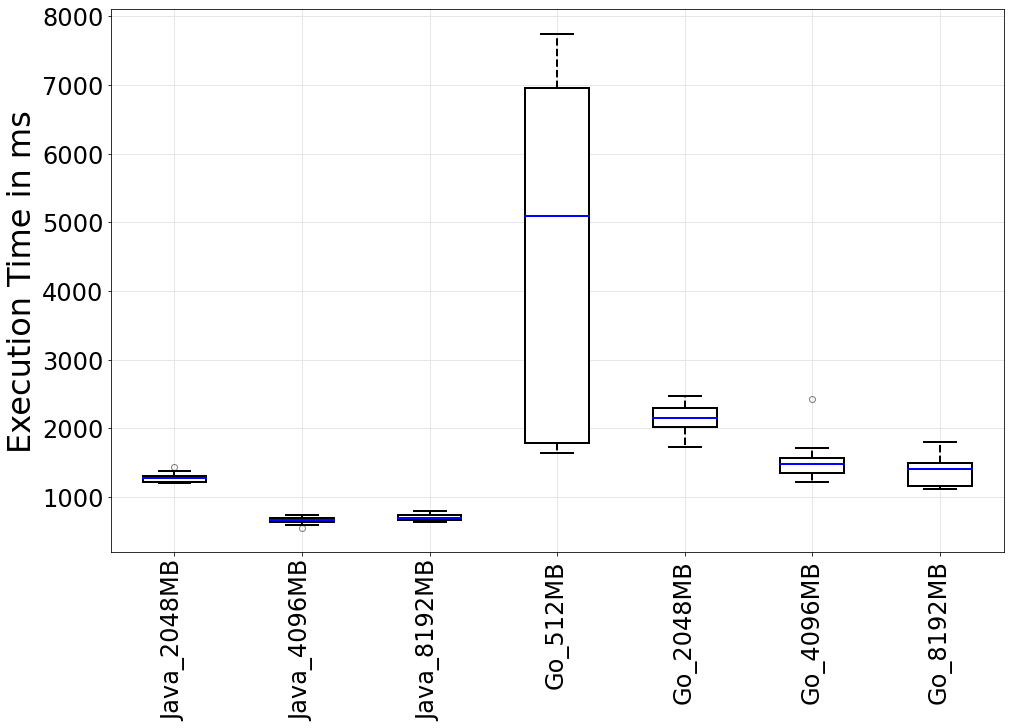

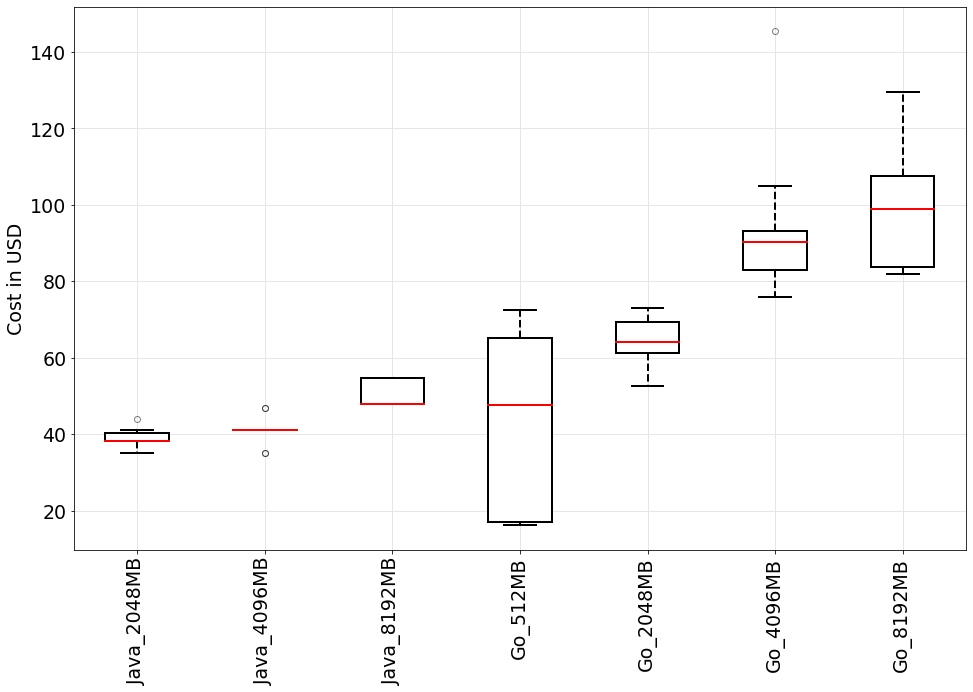

vm


In [435]:
# Execution Times and Cost
df_m = df_f[(df_f['Threads'] > 1)]
df_m = df_m.sort_values(by=['Memory'])
for s in services:
    print(s)
    tick_label_list = []
    series_list = []
    cost_list = []
    for l in languages:
        if l == ("python"):
            continue
        for m in mem_values:
            df_series = df_m[(df_m['Service'] == s) & (df_m['Language'] == l) & (df_m['Memory'] == m)]
            if ((s == 'google' or s == 'gcr') and m == 10240):
                continue
            if df_series.empty:
                continue
            # print(m, s, np.asarray(df_series['_value']))
            series_list.append(np.asarray(df_series['_value']))
            if(s == 'aws'):
                cost_list.append(calculate_costs_series_aws(np.asarray(df_series['_value']), m))
            if(s == 'google'):
                cost_list.append(calculate_costs_series_gcf(np.asarray(df_series['_value']), m))
            if(s == 'gcr'):
                cost_list.append(calculate_costs_series_gcr(np.asarray(df_series['_value']), m))
                   
            
            if(s == 'aws'):
                s_name = 'AWS'
            if(s == 'google'):
                s_name = 'GCF'
            if(s == 'gcr'):
                s_name = 'GCR'
            if(l == 'java'):
                l_name = 'Java'
            if(l == 'golang'):
                l_name = 'Go'
            if(l == 'c++'):
                l_name = 'C++'
            if(func == 'mvt'):
                func_name = 'MVT'
            else:
                func_name = func.capitalize()
            
            
            # name = func_name + "_" + s_name + "_" + l_name + "_" + str(m) + "MB"
            name = l_name + "_" + str(m) + "MB"
            tick_label_list.append(name)
    if len(tick_label_list) == 0:
        continue
    
    # Execution Time
    fig = plt.figure(1, figsize=(16, 10))
    rcParams['figure.figsize'] = 12, 6
    rcParams['axes.labelsize'] = 14
    rcParams['axes.titlesize'] = 20
    rcParams["font.size"] = 12
    rc('font', weight='normal')
    positions = []
    
    # Dont ask im too stupid to do this right
    for i in range(len(tick_label_list)):
        positions.insert(0, 0)
    for i in range(len(positions)):
        positions[i] = i
    ax = fig.add_subplot(111)
    bp = ax.boxplot(series_list, positions=positions, patch_artist=True)
    setBoxColors(bp, 'java')  
    ax.set_ylabel('Execution Time in ms', size=32.0)
    x_s = np.arange(len(tick_label_list))
    ax.set_xticks(x_s)
    ax.set_xticklabels(tick_label_list, rotation=90)
    ax.tick_params(axis='both', labelsize = 24.0)
    ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)


    fig.savefig("Graphs/ExecutionTimes/Exec_" + func_name + "_" + s_name + ".pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
    plt.show()
    
    # Cost
    if len(cost_list) == 0:
        continue
    fig = plt.figure(1, figsize=(16, 10))
    rcParams['figure.figsize'] = 12, 6
    rcParams['axes.labelsize'] = 14
    rcParams['axes.titlesize'] = 20
    rcParams["font.size"] = 12
    positions = []
    
    # Dont ask im too stupid to do this right
    for i in range(len(tick_label_list)):
        positions.insert(0, 0)
    for i in range(len(positions)):
        positions[i] = i
    ax = fig.add_subplot(111)
    bp = ax.boxplot(cost_list, positions=positions, patch_artist=True)
    setBoxColors(bp, 'c++')  
    ax.set_ylabel('Cost in USD', size=19.0)
    x_s = np.arange(len(tick_label_list))
    ax.set_xticks(x_s)
    ax.set_xticklabels(tick_label_list, rotation=90)
    ax.tick_params(axis='both', labelsize = 19.0)
    ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)



    plt.show()

aws


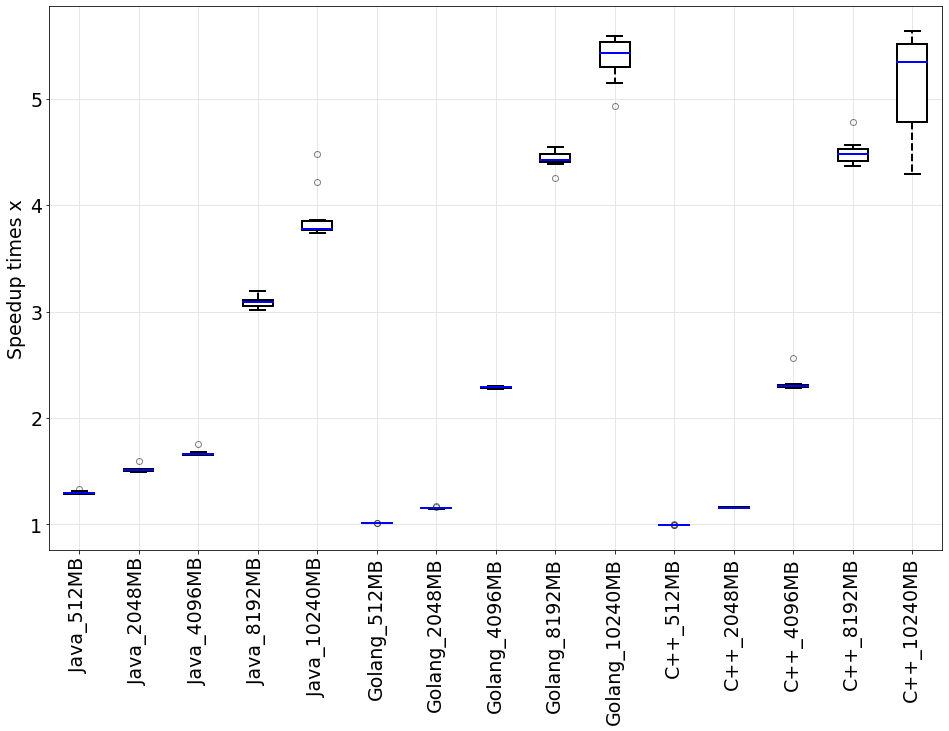

ow
gcr


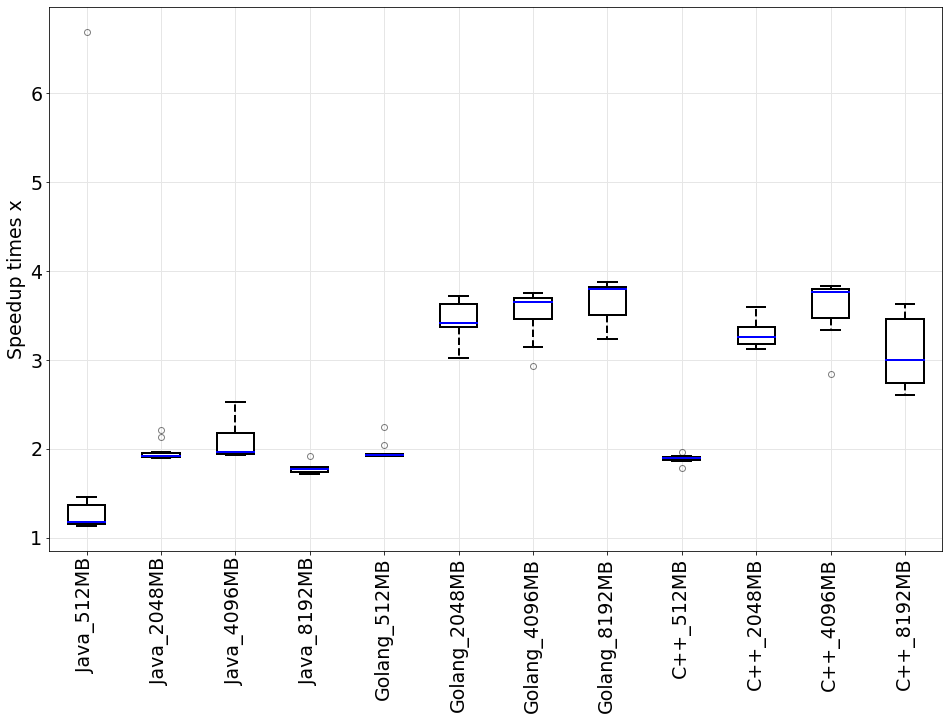

google


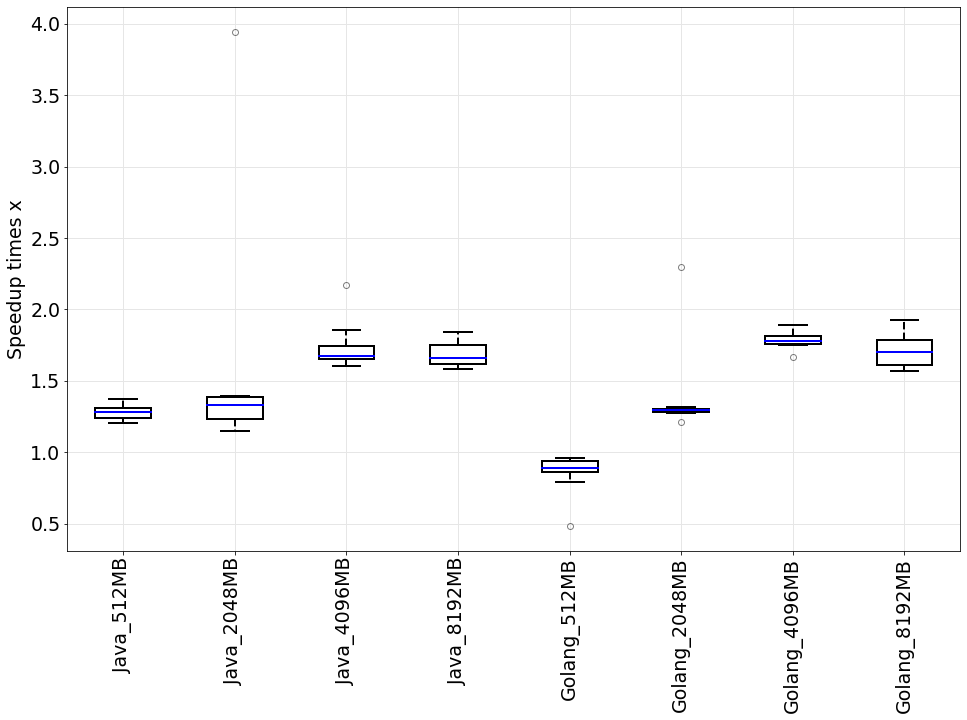

vm


In [26]:
# Speedup
df_m = df_f[(df_f['Threads'] > 1)]
df_s = df_f[(df_f['Threads'] == 1)]

for s in services:
    print(s)
    tick_label_list = []
    series_list = []
    for l in languages:
        if (l == "python"):
            continue
        for m in mem_values:
            if ((s == 'google' or s == 'gcr') and m == 10240):
                continue
            df_series_s = df_s[(df_s['Service'] == s) & (df_s['Language'] == l) & (df_s['Memory'] == m)]
            df_series_m = df_m[(df_m['Service'] == s) & (df_m['Language'] == l) & (df_m['Memory'] == m)]
            if df_series_m.empty:
                continue
            seq = np.asarray(df_series_s['_value'])
            par = np.asarray(df_series_m['_value'])
            seq = sorted(seq)
            par = sorted(par)

            speedup = []
            for i in range(len(seq)):
                if(i < len(par)):
                    speedup.append(seq[i] / par[i])
            
            smallest_dif = seq[0] / par[len(par) - 1]
            biggest_dif = seq[len(seq) - 1] / par[0]

            #speedup.append(smallest_dif)
            #speedup.append(biggest_dif)
            series_list.append(speedup)
            
            if(s == 'aws'):
                s_name = 'AWS'
            if(s == 'google'):
                s_name = 'GCF'
            if(s == 'gcr'):
                s_name = 'GCR'
            if(l == 'java'):
                l_name = 'Java'
            if(l == 'golang'):
                l_name = 'Golang'
            if(l == 'c++'):
                l_name = 'C++'
            if(func == 'mvt'):
                func_name = 'MVT'
            else:
                func_name = func.capitalize()
            
            
            # name = func_name + "_" + s_name + "_" + l_name + "_" + str(m) + "MB"
            name = l_name + "_" + str(m) + "MB"
            tick_label_list.append(name)

    if len(tick_label_list) == 0:
        continue
    
    # Execution Time
    fig = plt.figure(1, figsize=(16, 10))
    rcParams['figure.figsize'] = 12, 6
    rcParams['axes.labelsize'] = 14
    rcParams['axes.titlesize'] = 20
    rcParams["font.size"] = 12
    positions = []
    
    # Dont ask im too stupid to do this right
    for i in range(len(tick_label_list)):
        positions.insert(0, 0)
    for i in range(len(positions)):
        positions[i] = i
    ax = fig.add_subplot(111)
    bp = ax.boxplot(series_list, positions=positions, patch_artist=True)
    setBoxColors(bp, 'java')  
    ax.set_ylabel('Speedup times x', size=19.0)
    x_s = np.arange(len(tick_label_list))
    ax.set_xticks(x_s)
    ax.set_xticklabels(tick_label_list, rotation=90)
    ax.tick_params(axis='both', labelsize = 19.0)
    ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
    fig.savefig("Graphs/Par_Speedup_" + func_name + "_" + s_name + ".pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)


    plt.show()

aws


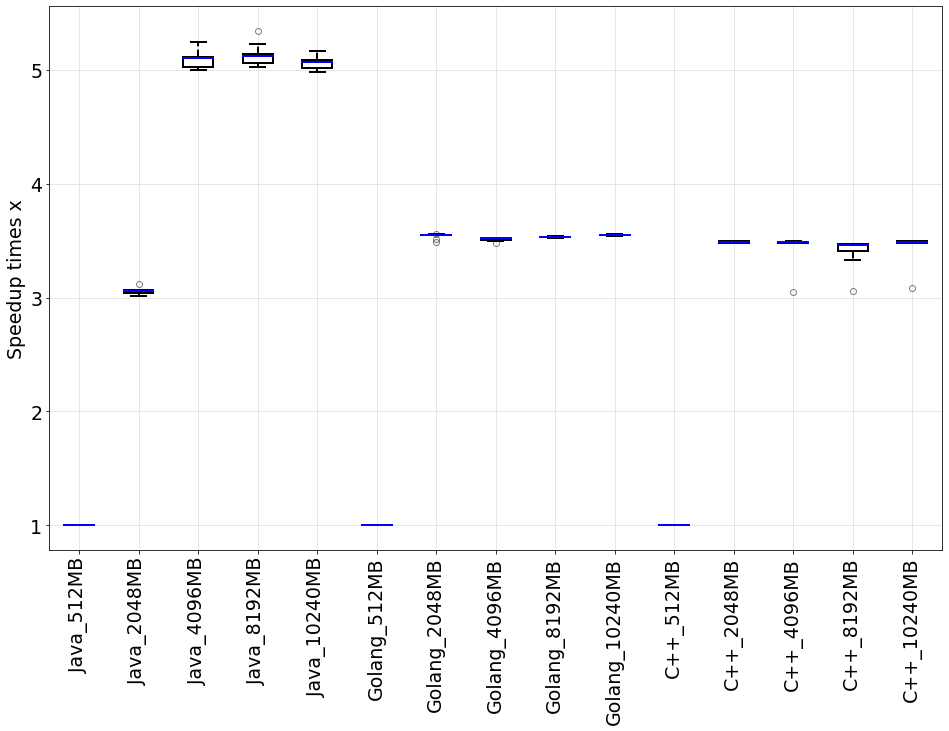

ow
gcr


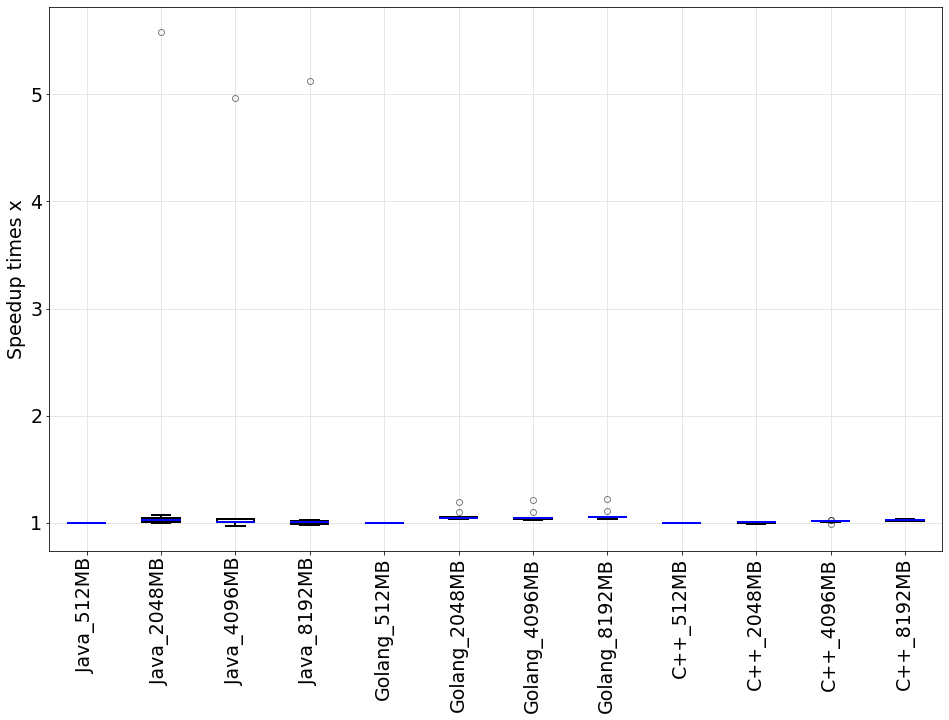

google


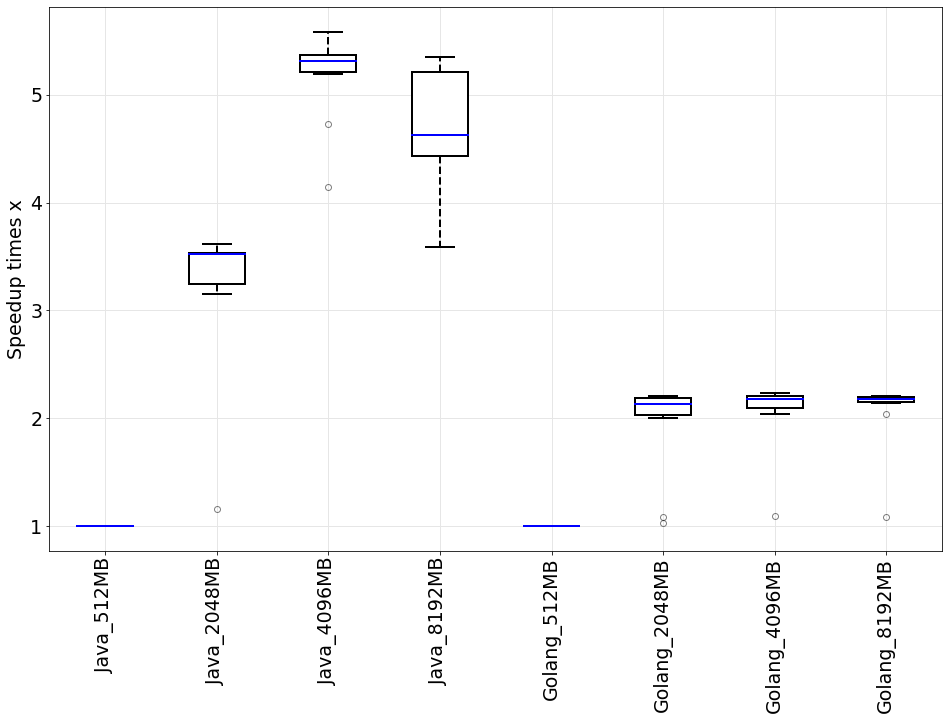

vm


In [27]:
# Sequential Speedup across configurations
df_m = df_f[(df_f['Threads'] == 1)]
df_s = df_f[(df_f['Threads'] == 1)]
for s in services:
    print(s)
    tick_label_list = []
    series_list = []
    for l in languages:
        if (l == "python"):
            continue
        for m in mem_values:
            if ((s == 'google' or s == 'gcr') and m == 10240):
                continue
            df_series_s = df_s[(df_s['Service'] == s) & (df_s['Language'] == l) & (df_s['Memory'] == 512)]
            df_series_m = df_m[(df_m['Service'] == s) & (df_m['Language'] == l) & (df_m['Memory'] == m)]
            if df_series_m.empty or df_series_s.empty:
                continue
            seq = np.asarray(df_series_s['_value'])
            par = np.asarray(df_series_m['_value'])
            seq = sorted(seq)
            par = sorted(par)

            speedup = []
            for i in range(len(seq)):
                if(i < len(par)):
                    speedup.append(seq[i] / par[i])
            
            #smallest_dif = seq[0] / par[len(par) - 1]
            #biggest_dif = seq[len(seq) - 1] / par[0]

            #speedup.append(smallest_dif)
            #speedup.append(biggest_dif)
            series_list.append(speedup)
            if(s == 'aws'):
                s_name = 'AWS'
            if(s == 'google'):
                s_name = 'GCF'
            if(s == 'gcr'):
                s_name = 'GCR'
            if(l == 'java'):
                l_name = 'Java'
            if(l == 'golang'):
                l_name = 'Golang'
            if(l == 'c++'):
                l_name = 'C++'
            if(func == 'mvt'):
                func_name = 'MVT'
            else:
                func_name = func.capitalize()
            
            # name = func_name + "_" + s_name + "_" + l_name + "_" + str(m) + "MB"
            name = l_name + "_" + str(m) + "MB"
            tick_label_list.append(name)

    if len(tick_label_list) == 0:
        continue
    
    # Execution Time
    fig = plt.figure(1, figsize=(16, 10))
    rcParams['figure.figsize'] = 12, 6
    rcParams['axes.labelsize'] = 14
    rcParams['axes.titlesize'] = 20
    rcParams["font.size"] = 12
    positions = []
    
    # Dont ask im too stupid to do this right
    for i in range(len(tick_label_list)):
        positions.insert(0, 0)
    for i in range(len(positions)):
        positions[i] = i
    ax = fig.add_subplot(111)
    bp = ax.boxplot(series_list, positions=positions, patch_artist=True)
    setBoxColors(bp, 'java')  
    ax.set_ylabel('Speedup times x', size=19.0)
    x_s = np.arange(len(tick_label_list))
    ax.set_xticks(x_s)
    ax.set_xticklabels(tick_label_list, rotation=90)
    ax.tick_params(axis='both', labelsize = 19.0)
    ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)


    fig.savefig("Graphs/Seq_Speedup_" + func_name + "_" + s_name + ".pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
    plt.show()

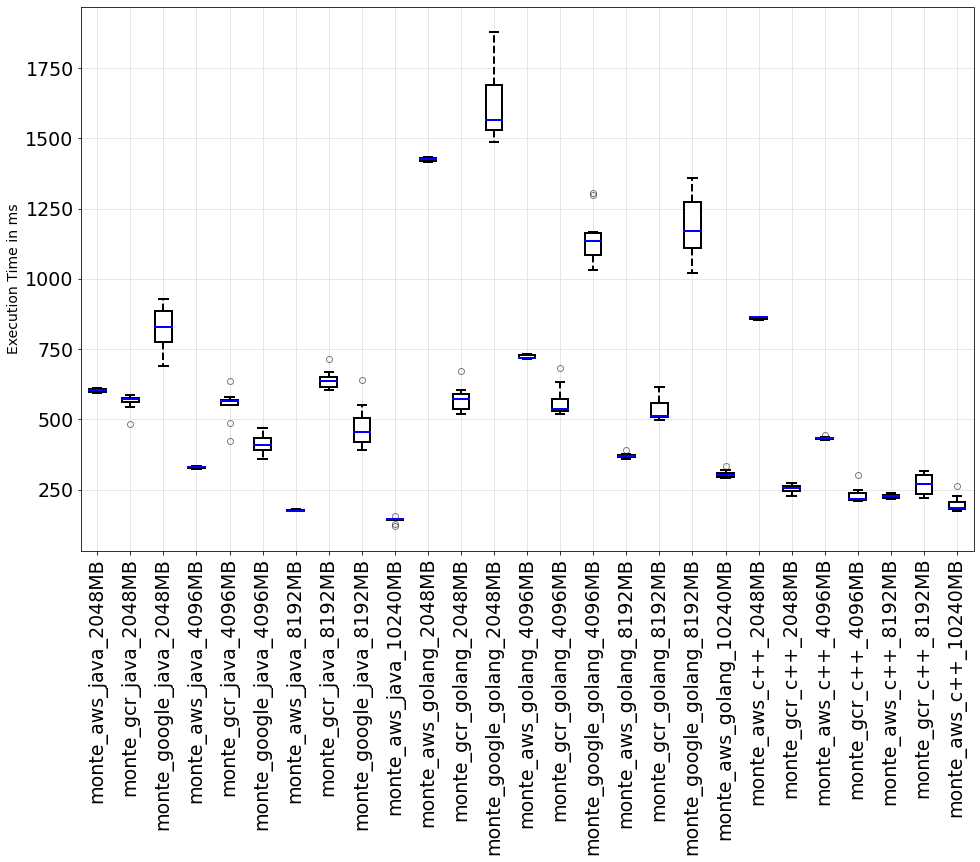

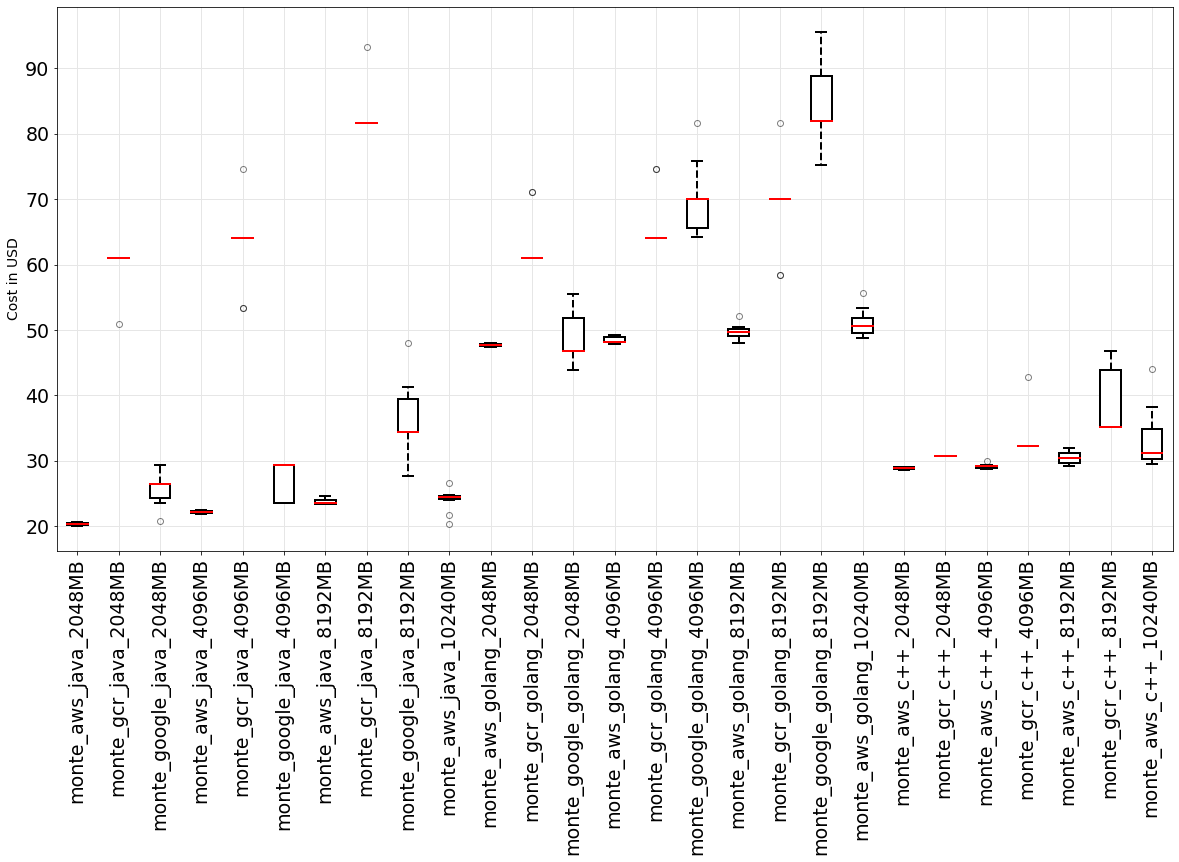

In [28]:
# Cost all Services
df_m = df_f[(df_f['Threads'] > 1)]
df_m = df_m.sort_values(by=['Memory'])
tick_label_list = []
tick_label_list_cost = []
series_list = []
cost_list = []

for l in languages:
    for m in mem_values:
        if(m == 512):
            continue
        for s in services:
            if ((s == 'google' or s == 'gcr') and m == 10240):
                continue

            df_series = df_m[(df_m['Service'] == s) & (df_m['Language'] == l) & (df_m['Memory'] == m)]
            if df_series.empty:
                continue
            name = func + "_" + s + "_" + l + "_" + str(m) + "MB"
            series_list.append(np.asarray(df_series['_value']))
            if(s == 'aws'):
                cost_list.append(calculate_costs_series_aws(np.asarray(df_series['_value']), m))
                tick_label_list_cost.append(name)
            if(s == 'google'):
                cost_list.append(calculate_costs_series_gcf(np.asarray(df_series['_value']), m))
                tick_label_list_cost.append(name)
            if(s == 'gcr'):
                cost_list.append(calculate_costs_series_gcr(np.asarray(df_series['_value']), m))
                tick_label_list_cost.append(name)
            
            tick_label_list.append(name)
    if len(tick_label_list) == 0:
        continue
    
# Execution Time
fig = plt.figure(1, figsize=(16, 10))
rcParams['figure.figsize'] = 12, 6
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
positions = []
    
# Dont ask im too stupid to do this right
for i in range(len(tick_label_list)):
    positions.insert(0, 0)
for i in range(len(positions)):
    positions[i] = i
ax = fig.add_subplot(111)
bp = ax.boxplot(series_list, positions=positions, patch_artist=True)
setBoxColors(bp, 'java')  
ax.set_ylabel('Execution Time in ms')
x_s = np.arange(len(tick_label_list))
ax.set_xticks(x_s)
ax.set_xticklabels(tick_label_list, rotation=90)
ax.tick_params(axis='both', labelsize = 19.0)
ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)



plt.show()
    
# Cost

fig = plt.figure(1, figsize=(20, 10))
rcParams['figure.figsize'] = 12, 6
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
positions = []
    
# Dont ask im too stupid to do this right
for i in range(len(tick_label_list_cost)):
    positions.insert(0, 0)
for i in range(len(positions)):
    positions[i] = i
ax = fig.add_subplot(111)
bp = ax.boxplot(cost_list, positions=positions, patch_artist=True)
setBoxColors(bp, 'c++')  
ax.set_ylabel('Cost in USD')
x_s = np.arange(len(tick_label_list_cost))
ax.set_xticks(x_s)
ax.set_xticklabels(tick_label_list_cost, rotation=90)
ax.tick_params(axis='both', labelsize = 19.0)
ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)



plt.show()

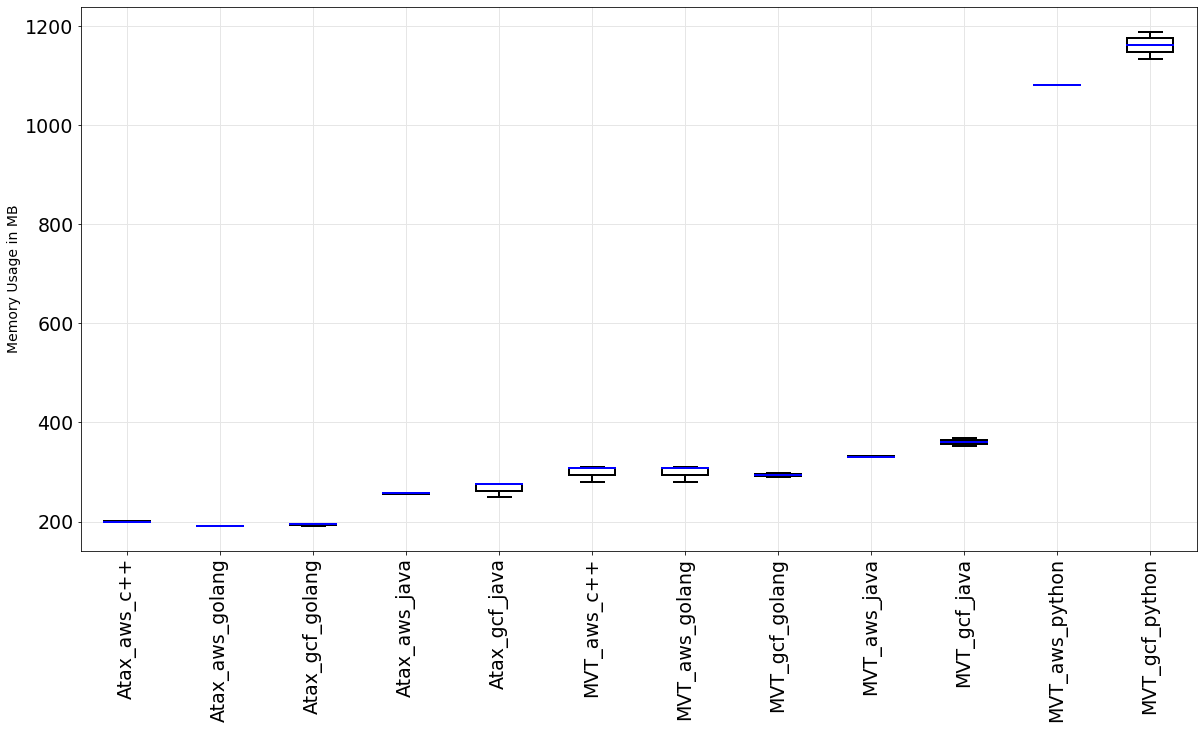

In [29]:
# Memory Usage
tick_label_list = []
series_list = []

tick_label_list.append("Atax_aws_c++")
series_list.append([199, 200, 201])

tick_label_list.append("Atax_aws_golang")
series_list.append([191, 191, 191])

tick_label_list.append("Atax_gcf_golang")
series_list.append([191.11, 195.77, 195.58])

tick_label_list.append("Atax_aws_java")
series_list.append([255, 258, 258])

tick_label_list.append("Atax_gcf_java")
series_list.append([249.86, 275.34, 275.47])

tick_label_list.append("MVT_aws_c++")
series_list.append([279, 308, 310])

tick_label_list.append("MVT_aws_golang")
series_list.append([279, 308, 310])

tick_label_list.append("MVT_gcf_golang")
series_list.append([289.24, 298.15])

tick_label_list.append("MVT_aws_java")
series_list.append([330, 331, 333])

tick_label_list.append("MVT_gcf_java")
series_list.append([351.57, 368.89])

tick_label_list.append("MVT_aws_python")
series_list.append([1081, 1082])

tick_label_list.append("MVT_gcf_python")
series_list.append([1162.6, 1133.8, 1188.8])

    
# Memory Usage

fig = plt.figure(1, figsize=(20, 10))
rcParams['figure.figsize'] = 12, 6
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
positions = []
    
# Dont ask im too stupid to do this right
for i in range(len(tick_label_list)):
    positions.insert(0, 0)
for i in range(len(positions)):
    positions[i] = i
ax = fig.add_subplot(111)
bp = ax.boxplot(series_list, positions=positions, patch_artist=True)
setBoxColors(bp, 'java')  
ax.set_ylabel('Memory Usage in MB')
x_s = np.arange(len(tick_label_list))
ax.set_xticks(x_s)
ax.set_xticklabels(tick_label_list, rotation=90)
ax.tick_params(axis='both', labelsize = 19.0)
ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)



plt.show()

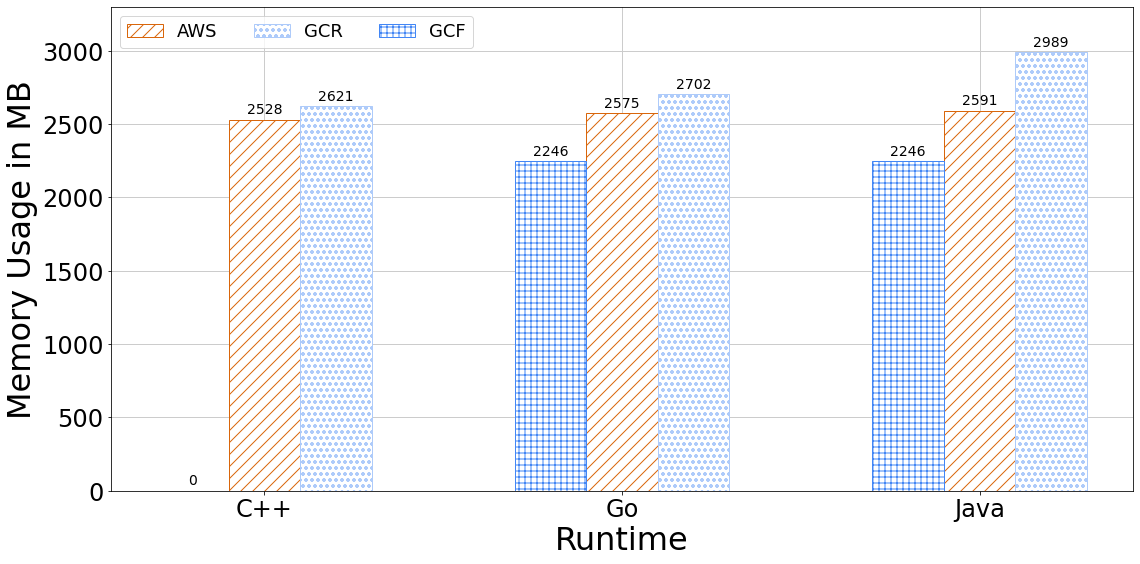

In [301]:
# Memory Usage MVT L
tick_label_list = []
series_list = []
langs = ['C++', 'Go', 'Java']
tick_label_list.append("MVT_aws_c++")
series_list.append([2527, 2528, 2529])

tick_label_list.append("MVT_gcr_c++")
series_list.append([2621])

tick_label_list.append("MVT_aws_Golang")
series_list.append([2575, 2575, 2577])

tick_label_list.append("MVT_gcr_Golang")
series_list.append([2702])

tick_label_list.append("MVT_gcf_Golang")
series_list.append([2246])

tick_label_list.append("MVT_aws_java")
series_list.append([2589, 2591, 2592, 2593])

tick_label_list.append("MVT_gcr_java")
series_list.append([2989])

tick_label_list.append("MVT_gcf_java")
series_list.append([2246])

    
# Memory Usage
aws_memories=np.asarray([2528, 2575, 2591])
gcr_memories=np.asarray([2621, 2702, 2989])
gcf_memories=np.asarray([0, 2246, 2246])
 
fig, ax = plt.subplots(figsize=(16,8))

x = np.arange(len(langs))
        
width = 0.20
offset = 1

aws_bar = ax.bar(x - width * (1 - offset), aws_memories, width, label='AWS', ecolor='#d9660b', edgecolor='#d9660b', color='w', hatch='//')
gcr_bar = ax.bar(x + width * offset, gcr_memories, width, label='GCR', ecolor='#aecbfa', edgecolor='#aecbfa', color='w', hatch='oo')
gcf_bar = ax.bar(x - width * offset, gcf_memories, width, label='GCF', ecolor='#4286f5', edgecolor='#4286f5', color='w', hatch='++')

ax.set_ylabel('Memory Usage in MB', size = 32.0)
ax.set_xlabel('Runtime', size = 32.0)
# ax.set_title('Maximum Memory Consumption for MVT',  size = 19.0)
ax.set_xticks(x)
ax.set_xticklabels(langs)
        
ax.bar_label(gcf_bar, padding=3, size=14)
ax.bar_label(aws_bar, padding=3, size=14)
ax.bar_label(gcr_bar, padding=3, size=14)


ax.tick_params(axis='both', labelsize = 24.0)
ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
ax.set_axisbelow(True)
ax.legend(prop={'size': 18}, loc='upper left', ncol=3)
ax.set_ylim([0, 3300])

fig.tight_layout()
fig.savefig("Graphs/Memory_Consumption.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
plt.show()

In [346]:
def indexHighestDiffPercentage(arr1, arr2):
    highestDiff = 0
    indexDiff = 0
    for i in range (len(arr1)):
        currDiff = arr1[i] - arr2[i]
        currDiffPerc = currDiff / arr1[i]
        print(currDiffPerc, highestDiff)
        if (currDiffPerc > highestDiff):
            highestDiff = currDiffPerc
            indexDiff = i
    return indexDiff

 
seq = [15.175, 40.8, 42.8, 35.199999999999996]
par = [10.25, 20.599999999999998, 21.599999999999998, 23.599999999999998]
print(indexHighestDiffPercentage(seq, par))

0.3245469522240528 0
0.4950980392156863 0.3245469522240528
0.4953271028037383 0.4950980392156863
0.32954545454545453 0.4953271028037383
2


In [285]:
def autolabel(rects, ax, min_value, val_wrt_max_speedup):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if min_value == val_wrt_max_speedup:
            if height == min_value:
#         min_value = calculate_min(height)
#         print(min_value)
                ax.annotate('{}'.format(round(height, 1)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize = 11, color="red", fontweight="bold")
            else:
                ax.annotate('{}'.format(round(height, 1)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize = 14)
        else:
            if height == min_value:
                 ax.annotate('{}'.format(round(height, 1)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize = 14, color="red", fontweight="bold")
            #elif height == val_wrt_max_speedup:
                  #ax.annotate('{}'.format(round(height, 1)),
                        #xy=(rect.get_x() + rect.get_width() / 2, height),
                        #xytext=(0, 3),  # 3 points vertical offset
                        #textcoords="offset points",
                        #ha='center', va='bottom', fontsize = 11, color="purple", fontweight="bold")
            else:
                 ax.annotate('{}'.format(round(height, 1)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize = 14)

In [484]:
def getFuncLabel(func):
    if (func == "atax"):
        return "Atax"
    if(func == "go_fast"):
        return "Go fast"
    if(func == "mvt"):
        return "MVT"
    if(func == "heat"):
        return "Heat"
    if(func == "monte"):
        return "Monte Carlo"
    return func

In [514]:
def getLangLabel(lang):
    if(lang == "java"):
        return "Java"
    if(lang == "golang"):
        return "Go"
    if(lang == "c++"):
        return "C++"
    return lang

In [286]:
# Import All Mean
df_all_mean = pd.read_csv('Commercial_Mean.csv', index_col=None, header=0)
lowest_diff = 100
highest_diff = 0

In [726]:
func = "heat"
inp = "M"
heat_mem_values = [2048, 4096, 8192, 10240]
heat_mem_values_short = [2048, 4096, 8192]
mem_values_gcr = [512, 2148, 4096, 8192]
df_f_mean = df_all_mean[(df_all_mean['Benchmark'] == func) & (df_all_mean['Input'] == inp)]
#df_f_mean = df_all_exec[(df_all_exec['Benchmark'] == func) & (df_all_exec['Input'] == inp)]
languages = ["java", "golang", "c++"]


aws [3467.2  993.8 1008.5 1020.  1006.4] [2798.   915.8  549.2  545.4  552.8] [5812.3 1641.2 1653.7 1645.2 1636.9]
aws [3483.6  860.5  433.6  226.9  199.2] [2157.7  604.1  329.2  176.7  142.5] [5756.7 1424.6  723.   371.7  305.2]
aws


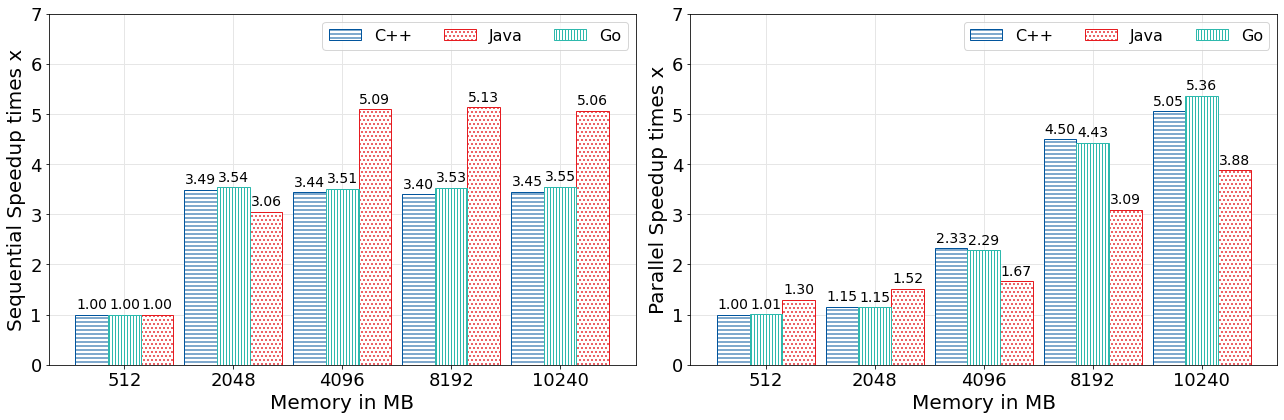

gcr [832.7902341 831.53006   821.4573061 813.8220326] [1706.425433  1103.6299655 1135.5945697 1139.4639561] [2095.5156955 1967.3354075 1972.8677346 1953.4860004]
[1062.9368604  572.531454   563.287679   533.4526014]
gcr [440.878946  253.7153635 230.2014403 267.873534 ] [928.8663747 561.4474894 549.6479972 641.2561859] [1062.9368604  572.531454   563.287679   533.4526014]
gcr
gcr [0 1 2 3] [512, 2048, 4096, 8192] [1706.425433  1103.6299655 1135.5945697 1139.4639561]
gcr [0 1 2 3] [512, 2048, 4096, 8192] [1706.425433  1103.6299655 1135.5945697 1139.4639561]


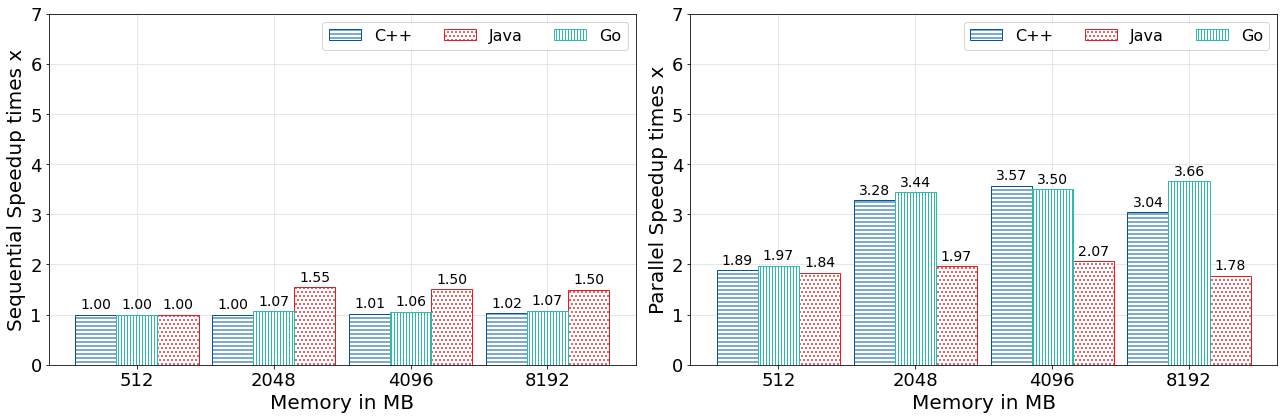

google [] [3668.7 1307.9  717.7  805.3] [4155.1        2260.4        2012.44444444 2018.9       ]
[4855.1 1611.7 1145.8 1185.3 1130.7]
google [] [2867.3  821.4  411.2  474.4] [4855.1 1611.7 1145.8 1185.3]
google
google [0 1 2 3] [512, 2048, 4096, 8192] [3668.7 1307.9  717.7  805.3]
google [0 1 2 3] [512, 2048, 4096, 8192] [3668.7 1307.9  717.7  805.3]


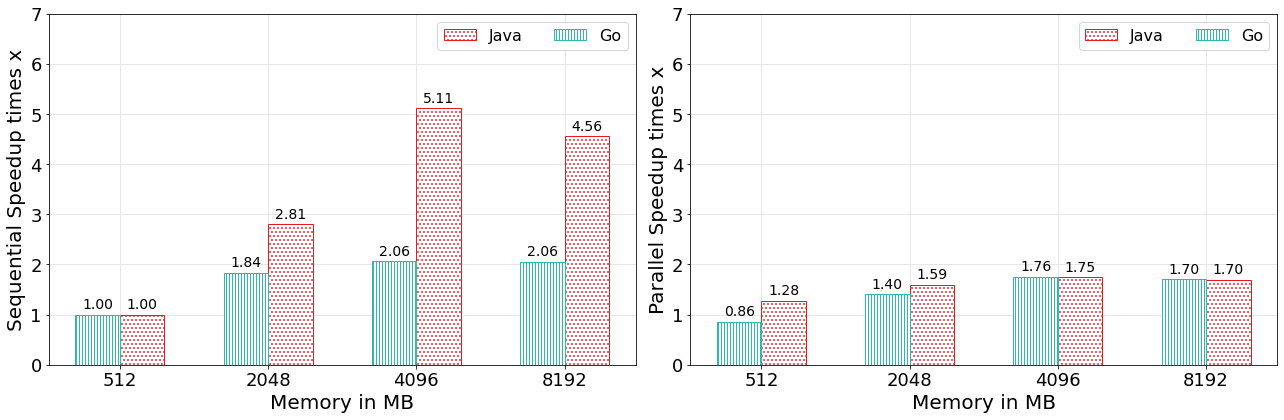

In [684]:
# Speedup side by side AWS Lambda
rcParams['figure.figsize'] = 18, 6
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12

df_m = df_f_mean[(df_f_mean['Threads'] > 1)]
df_s = df_f_mean[(df_f_mean['Threads'] == 1)]
df_m = df_m.sort_values(by=['Memory'])
df_s = df_s.sort_values(by=['Memory'])
df = df_s
for service in services:
    if(service == 'vm' or service == 'ow'):
        continue
    # ===================== SEQ SPEEDUP =========================
    seq_cpp = []
    seq_java = []
    seq_go = []

    function = func
    java_df = df[(df['Service'] == service) & (df['Language'] == 'java')]
    go_df = df[(df['Service'] == service) & (df['Language'] == 'golang')]
    cpp_df = df[(df['Service'] == service) & (df['Language'] == 'c++')]
    cpp_times=np.asarray(cpp_df['_value'])
    java_times=np.asarray(java_df['_value'])
    golang_times=np.asarray(go_df['_value'])
    
    # Have some values for 10GB but theyre actually 8GB -> delete last value
    if service == 'google' or  service == 'gcr':
        if(len(cpp_times) > 4):
            cpp_times = np.delete(cpp_times, 4)
        if(len(java_times) > 4):
            java_times = np.delete(java_times, 4)
        if(len(golang_times) > 4):
            golang_times = np.delete(golang_times, 4)
        
    print(service, cpp_times, java_times, golang_times)
    for i in range (len(golang_times)):
        seq_go.append(golang_times[0] / golang_times[i])
        if func != 'heat' or service == 'gcr':
            seq_java.append(java_times[0] / java_times[i])
        if service != 'google':
            seq_cpp.append(cpp_times[0] / cpp_times[i])
            
    # ==================== PAR SPEEDUP ===========================
    
    par_cpp = []
    par_java = []
    par_go = []

    function = func
    # seq
    java_df_seq = df_s[(df_s['Service'] == service) & (df_s['Language'] == 'java')]
    go_df_seq = df_s[(df_s['Service'] == service) & (df_s['Language'] == 'golang')]
    cpp_df_seq = df_s[(df_s['Service'] == service) & (df_s['Language'] == 'c++')]
    cpp_times_seq=np.asarray(cpp_df_seq['_value'])
    java_times_seq=np.asarray(java_df_seq['_value'])
    golang_times_seq=np.asarray(go_df_seq['_value'])
    
    java_df_par = df_m[(df_m['Service'] == service) & (df_m['Language'] == 'java')]
    go_df_par = df_m[(df_m['Service'] == service) & (df_m['Language'] == 'golang')]
    cpp_df_par = df_m[(df_m['Service'] == service) & (df_m['Language'] == 'c++')]
    cpp_times_par=np.asarray(cpp_df_par['_value'])
    java_times_par=np.asarray(java_df_par['_value'])
    golang_times_par=np.asarray(go_df_par['_value'])
    
    # Have some values for 10GB but theyre actually 8GB -> delete last value
    if service == 'google' or  service == 'gcr':
        if(len(cpp_times_par) > 4):
            cpp_times_seq = np.delete(cpp_times_seq, 4)
            cpp_times_par = np.delete(cpp_times_par, 4)
        if(len(java_times_par) > 4):
            java_times_seq = np.delete(java_times_seq, 4)
            java_times_par = np.delete(java_times_par, 4)
        print(golang_times_par)
        if(len(golang_times_par) > 4):
            golang_times_seq = np.delete(golang_times_seq, 4)
            golang_times_par = np.delete(golang_times_par, 4)
            
    if(func == 'heat' and service != 'gcr'):
        java_times_seq = np.insert(java_times_seq, 0, 0, axis=0)
        java_times_par = np.insert(java_times_par, 0, 0, axis=0)
            
    
        
    print(service, cpp_times_par, java_times_par, golang_times_par)
    for i in range (len(golang_times_par)):
        par_go.append(golang_times_seq[i] / golang_times_par[i])
        #if (func != 'heat' and i != 0) or service == 'gcr':
        par_java.append(java_times_seq[i] / java_times_par[i])
        if service != 'google':
            par_cpp.append(cpp_times_seq[i] / cpp_times_par[i])

    fig, (ax, ax2) = plt.subplots(1, 2)

    x_1 = np.arange(len(mem_values))
    if(service == 'google' or service == 'gcr'):
        x_1 = x_1 = np.arange(len(mem_values_short))
        
    width = 0.30
    offset = 0.5
    print(service)
    if(service != 'google'):
        offset = 0
        if(func == 'heat' and service == 'aws'):
            offset = 0.5
        cpp_bar = ax.bar(x_1 - width * (1 - offset * (3)), seq_cpp, width, label='C++', ecolor='#01559d', edgecolor='#01559d', color='w', hatch='---')
        ax.bar_label(cpp_bar, padding=3, fmt='%1.2f', size=14)
    if func != 'heat' or service == 'gcr':
        java_bar = ax.bar(x_1 + width * (1 - offset), seq_java, width, label='Java', ecolor='#e61c21', edgecolor='#e61c21', color='w', hatch='...')
        ax.bar_label(java_bar, padding=3, fmt='%1.2f', size=14)
    if(service == 'google' and func == 'heat'):
        offset = 0
    go_bar = ax.bar(x_1 - width * (0 + offset), seq_go, width, label='Go', ecolor='#2eb9ad', edgecolor='#2eb9ad', color='w', hatch='||||')

    ax.set_ylabel('Sequential Speedup times x', size=20.0)
    ax.set_xlabel('Memory in MB', size=20.0)
    ax.set_xticks(x_1)
    if(service == 'google' or service == 'gcr'):
        print(service, x_2, mem_values_L_short, java_times)
        ax.set_xticklabels(mem_values_short)
    else:
        ax.set_xticklabels(mem_values_L)
    ax.legend(prop={'size': 16}, loc='upper right', ncol=3)
    ax.set_ylim([0,7])
    ax.bar_label(go_bar, padding=3, fmt='%1.2f', size=14)

    ax.tick_params(axis='both', labelsize = 18.0)
    ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    
    # SEQ ========
    
    if(service != 'google'):
        offset = 0
        cpp2_bar = ax2.bar(x_1 - width * (1 - offset * (3)), par_cpp, width, label='C++', ecolor='#01559d', edgecolor='#01559d', color='w', hatch='---')
        ax2.bar_label(cpp2_bar, padding=3, fmt='%1.2f', size=14)
    #if func != 'heat' or service == 'gcr':
    java2_bar = ax2.bar(x_1 + width * (1 - offset), par_java, width, label='Java', ecolor='#e61c21', edgecolor='#e61c21', color='w', hatch='...')
    ax2.bar_label(java2_bar, padding=3, fmt='%1.2f', size=14)
    go2_bar = ax2.bar(x_1 - width * (0 + offset), par_go, width, label='Go', ecolor='#2eb9ad', edgecolor='#2eb9ad', color='w', hatch='||||')

    ax2.set_ylabel('Parallel Speedup times x', size=20.0)
    ax2.set_xlabel('Memory in MB', size=20.0)
    ax2.set_xticks(x_1)
    ax2.tick_params(axis='both', labelsize = 18.0)
    if(service == 'google' or service == 'gcr'):
        print(service, x_2, mem_values_L_short, java_times)
        ax2.set_xticklabels(mem_values_short)
    else:
        ax2.set_xticklabels(mem_values)
    ax2.legend(prop={'size': 16}, loc='upper right', ncol=3)
    ax2.set_ylim([0,7])

    ax2.bar_label(go2_bar, padding=3, fmt='%1.2f', size=14)
    ax2.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
    ax2.set_axisbelow(True)
    fig.tight_layout()
    fig.savefig("Graphs/Performance/Speedup_Mean_" + func + "_" + service + ".png",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
    plt.show()

[3483.6  860.5  433.6  226.9  199.2]
[3483.6  860.5  433.6  226.9  199.2] [29.113879999999998, 28.85465, 29.121119999999998, 30.445770000000003, 33.40664]
[2157.7  604.1  329.2  176.7  142.5] [18.108909999999998, 20.31653, 22.157639999999997, 23.75411, 23.95475]
[5756.7 1424.6  723.   371.7  305.2] [47.98061, 47.63918, 48.4241, 49.74761000000001, 51.076840000000004]
Speedup: 1.0
Cost Increase: 1.0
Speedup: 4.048343986054619
Cost Increase: 0.9910959995713385
Speedup: 8.034132841328413
Cost Increase: 1.0002486786371312
Speedup: 15.35301895107977
Cost Increase: 1.0457475953050575
Speedup: 17.487951807228917
Cost Increase: 1.1474471970070634
aws


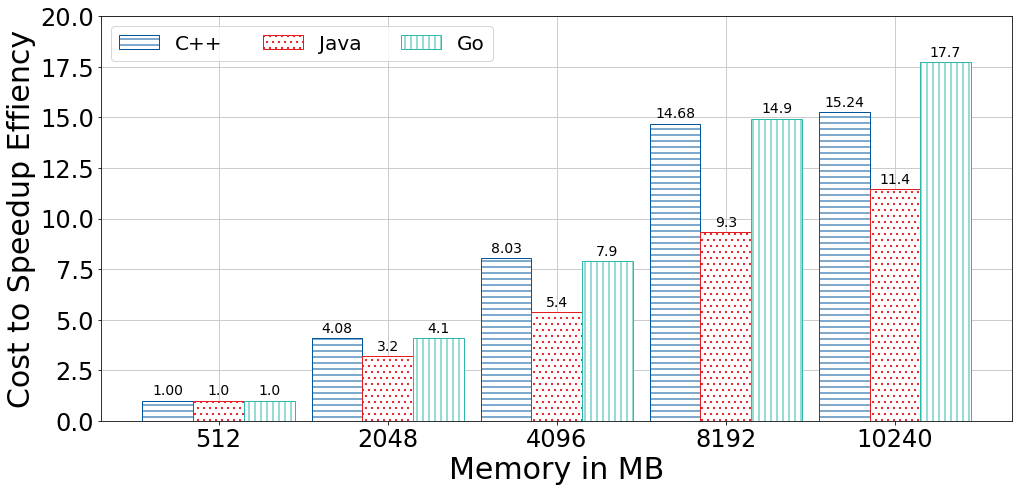

[440.878946  253.7153635 230.2014403 267.873534 ] [25.025, 30.7, 32.2, 35.199999999999996]
Speedup: 1.0
Cost Increase: 1.0
Speedup: 1.737691166660469
Cost Increase: 1.2267732267732268
Speedup: 1.9151876088413855
Cost Increase: 1.2867132867132869
Speedup: 1.6458473497422854
Cost Increase: 1.4065934065934065
gcr
gcr [0 1 2 3] [512, 2048, 4096, 8192] [928.8663747 561.4474894 549.6479972 641.2561859]


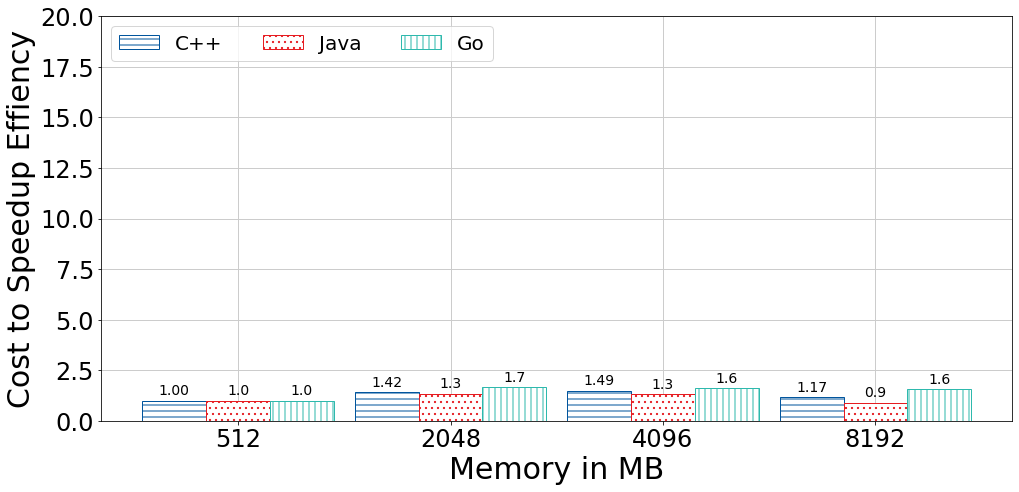

IndexError: list index out of range

In [685]:
# Efficiency again
rc('font', weight='normal')
df = df_f_mean[(df_f_mean['Threads'] > 1)]
df = df.sort_values(by=['Memory'])
mem_values_L = [512, 2048, 4096, 8192, 10240]
mem_values_L_short = [512, 2048, 4096, 8192]
for service in services:
    if(service == 'vm' or service == 'ow'):
        continue
    
    efficiency_cpp = []
    efficiency_java = []
    efficiency_go = []

    function = func
    java_df = df[(df['Service'] == service) & (df['Language'] == 'java')]
    go_df = df[(df['Service'] == service) & (df['Language'] == 'golang')]
    cpp_df = df[(df['Service'] == service) & (df['Language'] == 'c++')]
    cpp_times=np.asarray(cpp_df['_value'])
    java_times=np.asarray(java_df['_value'])
    golang_times=np.asarray(go_df['_value'])
        
    # Costs Efficiency: 
    # (Speedup between lowest config and index config) 
    # / 
    # (Cost increase between lowest config and index config)
    if (service == 'aws'):
        print(cpp_times)
        cost_cpp = calculate_costs_aws(cpp_times, 0)
        print(cpp_times, cost_cpp)
        cost_java = calculate_costs_aws(java_times, 0)
        print(java_times, cost_java)
        # golang_times = np.insert(golang_times, 0, 30000)
        cost_go = calculate_costs_aws(golang_times, 0)

        print(golang_times, cost_go)
        
        for i in range(len(cost_cpp)):
            print("Speedup: " + str(cpp_times[0] / cpp_times[i]))
            print("Cost Increase: " + str(cost_cpp[i] / cost_cpp[0]))
            efficiency_cpp.append((cpp_times[0] / cpp_times[i]) / (cost_cpp[i] / cost_cpp[0]))
            efficiency_java.append((java_times[0] / java_times[i]) / (cost_java[i] / cost_java[0]))
            efficiency_go.append((golang_times[0] / golang_times[i]) / (cost_go[i] / cost_go[0]))
    if (service == 'google'):
        cost_java = calculate_costs_gcf(java_times)
        cost_go = calculate_costs_gcf(golang_times)
        for i in range(len(cost_cpp)):
            efficiency_java.append((java_times[0] / java_times[i]) / (cost_java[i] / cost_java[0]))
            efficiency_go.append((golang_times[0] / golang_times[i]) / (cost_go[i] / cost_go[0]))
    if (service == 'gcr'):
        cost_cpp = calculate_costs_gcr(cpp_times)
        cost_java = calculate_costs_gcr(java_times)
        cost_go = calculate_costs_gcr(golang_times)
        print(cpp_times, cost_cpp)
        for i in range(len(cost_cpp)):
            print("Speedup: " + str(cpp_times[0] / cpp_times[i]))
            print("Cost Increase: " + str(cost_cpp[i] / cost_cpp[0]))
            efficiency_cpp.append((cpp_times[0] / cpp_times[i]) / (cost_cpp[i] / cost_cpp[0]))
            efficiency_java.append((java_times[0] / java_times[i]) / (cost_java[i] / cost_java[0]))
            efficiency_go.append((golang_times[0] / golang_times[i]) / (cost_go[i] / cost_go[0]))
                
            
 
    fig, ax = plt.subplots(figsize=(14,7))

    x_1 = np.arange(len(mem_values_L))
    if(service == 'google' or service == 'gcr'):
        x_1 = x_2
        
    width = 0.30
    offset = 0.5
    print(service)
    if(service != 'google'):
        offset = 0
        cpp_bar = ax.bar(x_1 - width * 1, efficiency_cpp, width, label='C++', ecolor='#01559d', edgecolor='#01559d', color='w', hatch='--')
        ax.bar_label(cpp_bar, padding=3, fmt='%1.2f', size=14)
    java_bar = ax.bar(x_1 - width * (0 + offset), efficiency_java, width, label='Java', ecolor='#e61c21', edgecolor='#e61c21', color='w', hatch='..')
    go_bar = ax.bar(x_1 + width * (1 - offset), efficiency_go, width, label='Go', ecolor='#2eb9ad', edgecolor='#2eb9ad', color='w', hatch='||')

    ax.set_ylabel('Cost to Speedup Effiency', size=30.0)
    ax.set_xlabel('Memory in MB', size=30.0)
        
    if(service == 'google' or service == 'gcr'):
        print(service, x_2, mem_values_short, java_times)
        ax.set_xticks(x_2)
        ax.set_xticklabels(mem_values_short)
    else:
        ax.set_xticks(x_1)
        ax.set_xticklabels(mem_values)
    ax.legend(prop={'size': 20}, loc='upper left', ncol=3)
    if(service == 'aws'):
        ax.set_ylim([0, 20])
    if(service == 'gcr'):
        ax.set_ylim([0, 5])
    if(service == 'google'):
        ax.set_ylim([0, 7.5])
        
    ax.bar_label(java_bar, padding=3, fmt='%1.1f', size=14)
    ax.bar_label(go_bar, padding=3, fmt='%1.1f', size=14)
    ax.set_ylim([0, 20])
    ax.tick_params(axis='both', labelsize = 24.0)
    ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    fig.tight_layout()
    fig.savefig("Graphs/Efficiency/Efficiency_" + func + "_" + service + ".pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
    plt.show()


[2157.7  604.1  329.2  176.7  142.5]
java [23.423399999999997, 30.69614, 36.83164, 72.90182, 92.35176] [18.108909999999998, 20.31653, 22.157639999999997, 23.75411, 23.95475]
0.2268880691957615 0
0.338140560995617 0.2268880691957615
0.3984074561979864 0.338140560995617
0.6741630044352802 0.3984074561979864
0.7406140391910235 0.6741630044352802


<ipython-input-686-43d075a1218d>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mem_values)


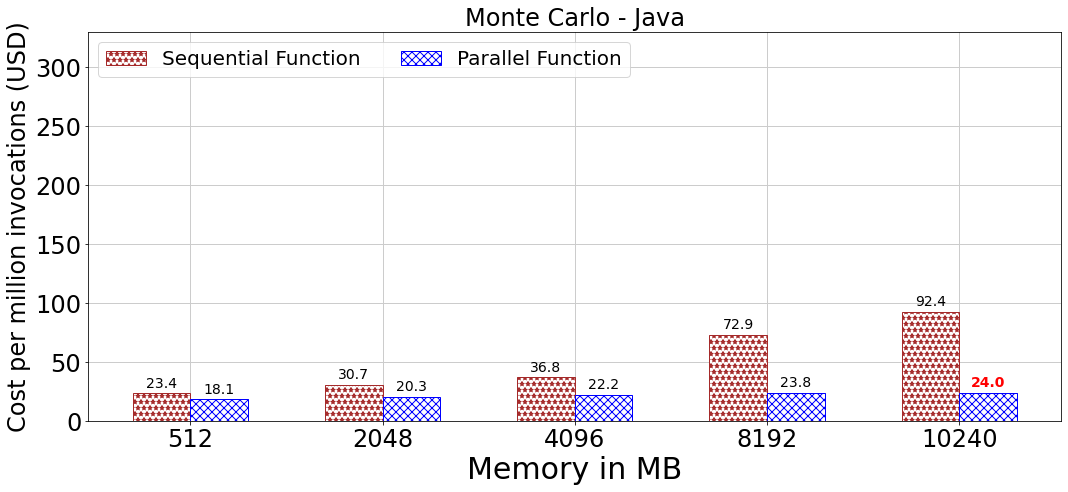

[5756.7 1424.6  723.   371.7  305.2]
golang [48.44209, 54.851960000000005, 110.50179, 219.50516000000002, 273.07123] [47.98061, 47.63918, 48.4241, 49.74761000000001, 51.076840000000004]
0.009526426295810145 0
0.13149539232508742 0.009526426295810145
0.5617799494469727 0.13149539232508742
0.773364735480478 0.5617799494469727
0.812954151193445 0.773364735480478


<ipython-input-686-43d075a1218d>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mem_values)


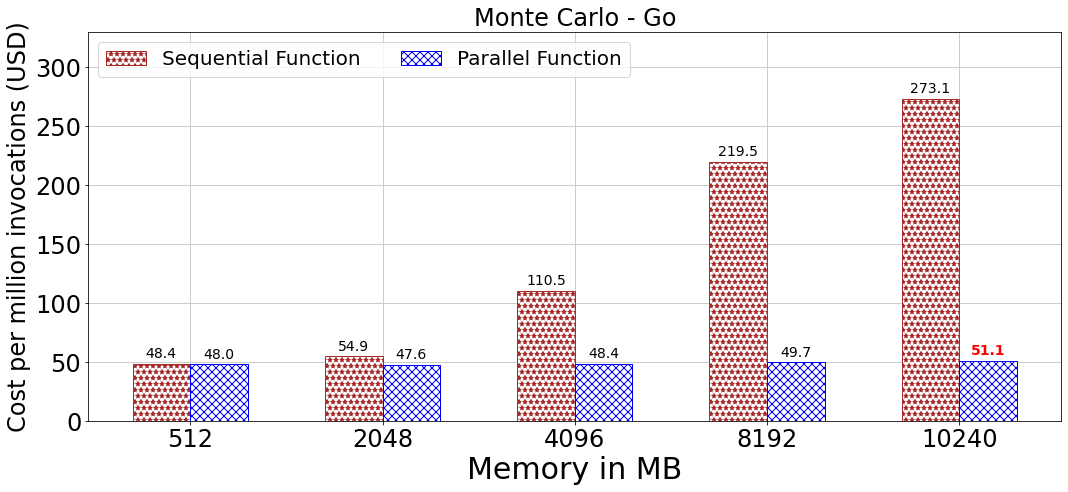

[3483.6  860.5  433.6  226.9  199.2]
c++ [28.97776, 33.29354, 67.46695, 136.166, 167.96688] [29.113879999999998, 28.85465, 29.121119999999998, 30.445770000000003, 33.40664]
-0.004697395519874492 0
0.13332586441694097 0
0.5683646585476296 0.13332586441694097
0.7764069591527987 0.5683646585476296
0.8011117429817116 0.7764069591527987


<ipython-input-686-43d075a1218d>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mem_values)


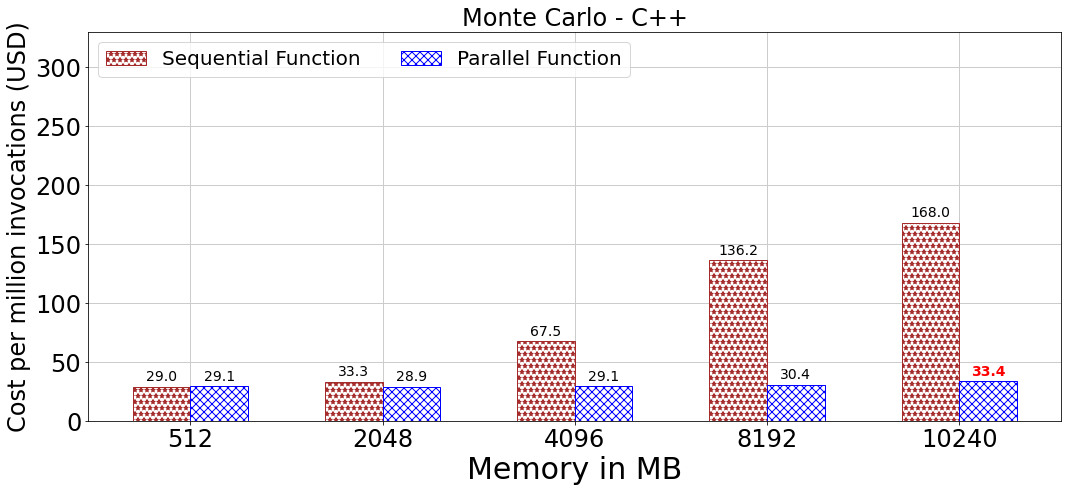

In [686]:
# Scenario 1 - Sequential vs Parallel Cost

# Cost Comparison services AWS
df_m = df_f_mean[(df_f_mean['Threads'] > 1)]
df_s = df_f_mean[(df_f_mean['Threads'] == 1)]
df_m = df_m.sort_values(by=['Memory'])
df_s = df_s.sort_values(by=['Memory'])

for l in languages:
    if (l == 'python'):
        continue
    aws_seq = df_s[(df_s['Service'] == 'aws') & (df_s['Language'] == l)]
    aws_par = df_m[(df_m['Service'] == 'aws') & (df_m['Language'] == l)]
    aws_seq = np.asarray(aws_seq['_value'])
    aws_par = np.asarray(aws_par['_value'])
    if(func == 'heat' and l == 'java'):
        aws_seq = np.insert(aws_seq, 0, 0)
        aws_par = np.insert(aws_par, 0, 0)
        
    aws_costs_seq = calculate_costs_aws(aws_seq)
    aws_costs_par = calculate_costs_aws(aws_par)
    

    
    print(aws_par)
    print(l, aws_costs_seq, aws_costs_par)
    fig, ax = plt.subplots(figsize=(15,7))
    
    if(func == 'heat' and l == 'java'):
        aws_costs_seq = np.delete(aws_costs_seq, 0)
        aws_costs_par = np.delete(aws_costs_par, 0)
        x = np.arange(len(heat_mem_values))
        ax.set_xticklabels(heat_mem_values)
    else:
        x = np.arange(len(mem_values))
        ax.set_xticklabels(mem_values)

    width = 0.30
    offset = 0.5
    #offset = 0
    seq_bar = ax.bar(x - width * offset , aws_costs_seq, width, ecolor='blue', edgecolor='brown', label='Sequential Function', color = 'w', hatch = '**')
    par_bar = ax.bar(x + width * offset , aws_costs_par, width, ecolor='blue', edgecolor='blue', label='Parallel Function', color = 'w', hatch = 'xxx')

    ax.set_ylabel('Cost per million invocations (USD)', size=24.0)
    ax.set_xlabel('Memory in MB', size=30.0)
    # ax.set_title('Cost Comparison in ' + l)
    ax.set_xticks(x)
    
    ax.legend(prop={'size': 20}, loc='upper left')
    diffIndex = indexHighestDiffPercentage(aws_costs_seq, aws_costs_par)
    ax.bar_label(seq_bar, padding=3, fmt='%1.1f', size=14)
    #ax.bar_label(par_bar, padding=3, fmt='%1.2f', size=14)
    autolabel(par_bar, ax, aws_costs_par[diffIndex], 0)
    ax.tick_params(axis='both', labelsize = 24.0)
    ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
    ax.legend(prop={'size': 20}, loc='upper left', ncol=3)
    ax.set_ylim([0,330])
    ax.set_axisbelow(True)
    
    ax.set_title(getFuncLabel(func) + ' - ' + getLangLabel(l), size=24)

    fig.tight_layout()
    fig.savefig("Graphs/Cost_Normal_PNG/Cost_" + func + "_" + l + "_AWS.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

    plt.show()
    
    


[3458.6  919.2  462.9  295.   236.8]
java [30.357219999999998, 36.87995, 44.98905, 91.27056, 109.17179] [29.113879999999998, 28.85465, 29.121119999999998, 30.445770000000003, 33.40664]


<ipython-input-690-a1e92e37ca6f>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mem_values)


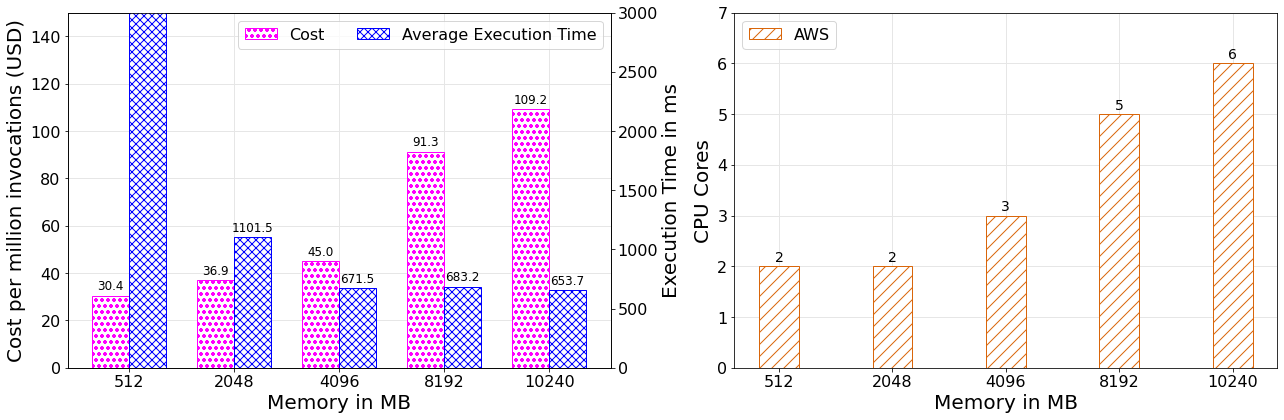

[3087.3  745.9  401.6  226.8  203.2]
golang [26.738419999999998, 29.06111, 60.2967, 117.77060000000002, 147.62948] [29.113879999999998, 28.85465, 29.121119999999998, 30.445770000000003, 33.40664]


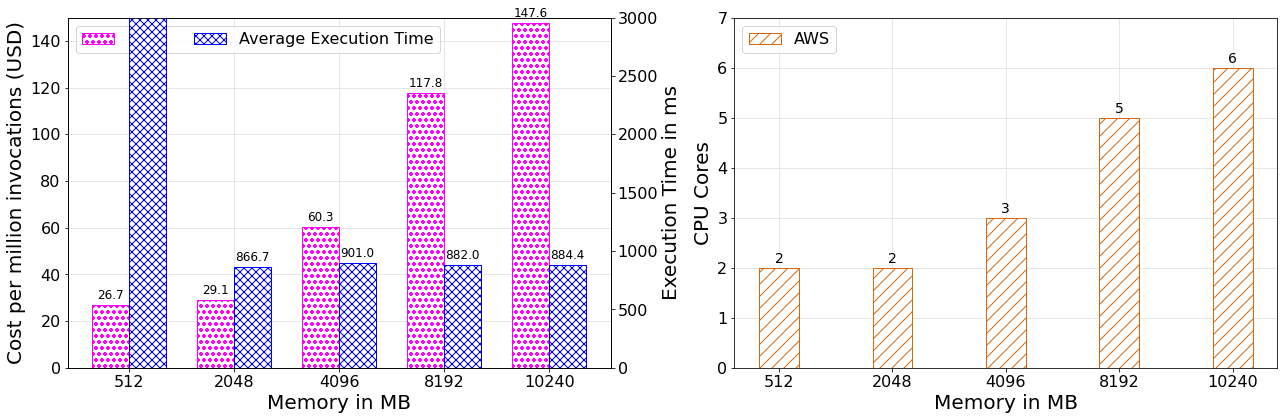

[2541.5  622.4  339.4  185.   154.8]
c++ [20.141579999999998, 22.4777, 49.304539999999996, 95.70945, 116.5566] [29.113879999999998, 28.85465, 29.121119999999998, 30.445770000000003, 33.40664]


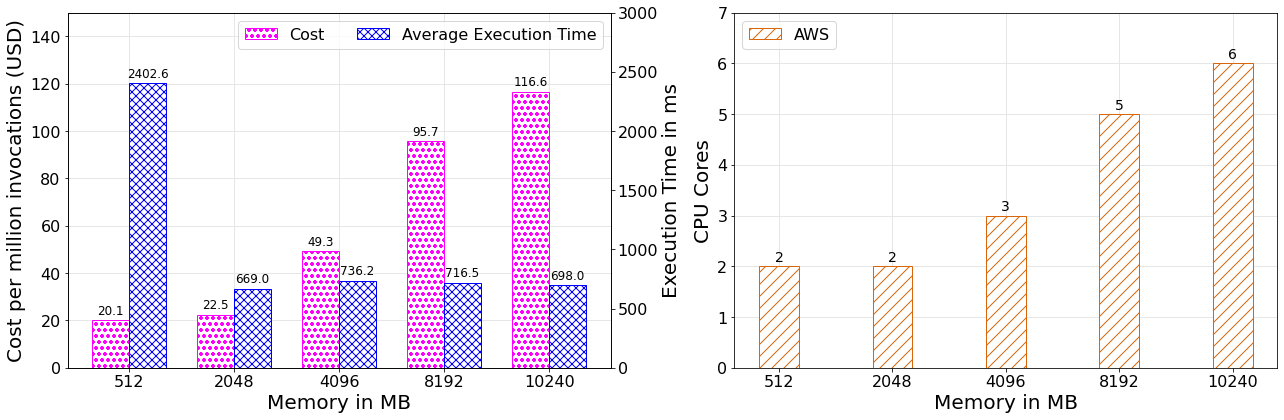

In [690]:
# Combined Motivation Example
from matplotlib.legend_handler import HandlerLine2D
rcParams['figure.figsize'] = 18, 6
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
# Cost Comparison services AWS
df_m = df_f_mean[(df_f_mean['Threads'] > 1)]
df_s = df_f_mean[(df_f_mean['Threads'] == 1)]
df_m = df_m.sort_values(by=['Memory'])
df_s = df_s.sort_values(by=['Memory'])

for l in languages:
    if (l == 'python'):
        continue
    aws_seq = df_s[(df_s['Service'] == 'aws') & (df_s['Language'] == l)]
    aws_par = df_m[(df_m['Service'] == 'aws') & (df_m['Language'] == l)]
    aws_seq = np.asarray(aws_seq['_value'])
    aws_par = np.asarray(aws_par['_value'])
    if(func == 'heat' and l == 'java'):
        aws_seq = np.insert(aws_seq, 0, 0)
        aws_par = np.insert(aws_par, 0, 0)
        
    aws_costs_seq = calculate_costs_aws(aws_seq)
    # aws_costs_par = calculate_costs_aws(aws_par)
    exec_seq = aws_seq
    

    
    print(aws_par)
    print(l, aws_costs_seq, aws_costs_par)
    fig, (ax, ax2) = plt.subplots(1, 2)
    
    if(func == 'heat' and l == 'java'):
        aws_costs_seq = np.delete(aws_costs_seq, 0)
        aws_costs_par = np.delete(aws_costs_par, 0)
        x = np.arange(len(heat_mem_values))
        ax.set_xticklabels(heat_mem_values)
    else:
        x = np.arange(len(mem_values))
        ax.set_xticklabels(mem_values)

    width = 0.35
    offset = 0.5
    # offset = 0
    ax3 = ax.twinx()
    # seq_bar = ax.bar(x - width * offset , aws_costs_seq, width, ecolor='blue', edgecolor='brown', label='Cost', color = 'w', hatch = '**')
    seq_bar = ax.bar(x - width * offset , aws_costs_seq, width, ecolor='blue', edgecolor='magenta', label='Cost', color = 'w', hatch = 'oo')

    # exec_bar = ax2.bar(x + width * offset , exec_seq, width, ecolor='green', edgecolor='green', label='Execution Time', color = 'w', hatch = '..')
    exec_bar = ax3.bar(x + width * offset , exec_seq, width, capsize=2, ecolor='blue', edgecolor='blue', label='Average Execution Time', color = 'w', hatch = 'xxx')

    ax.set_ylabel('Cost per million invocations (USD)', size=20.0)
    ax.set_ylim([0,150])
    ax.set_xlabel('Memory in MB', size=20.0)
    ax3.set_ylabel('Execution Time in ms', size=20.0)
    ax3.set_ylim([0,3000])
    # ax.set_title('Cost Comparison in ' + l)
    ax.set_xticks(x)
    
    #ax.legend(prop={'size': 20}, loc='upper center')
    #ax2.legend(prop={'size': 20}, loc='upper center')
    #plt.legend(prop={'size': 20}, loc='upper center')
    #plt.legend(handler_map={seq_bar: HandlerLine2D(numpoints=4)})
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc=0, fontsize=16.0, ncol=2)
    #ax.legend(lns, labs, loc=0)
    #handles = [plt.Rectangle((0,0),1,1, color=colors[label], hatches='xx') for label in labels]
    #plt.legend(handles, labels, prop={'size': 20}, loc='upper center')
    #plt.legend(prop={'size': 20}, loc='upper center')
    ax.bar_label(seq_bar, padding=3, fmt='%1.1f', size=12)
    
    ax3.bar_label(exec_bar, padding=3, fmt='%1.1f', size=12)
    
    ax.tick_params(axis='both', labelsize = 16.0)
    ax3.tick_params(axis='both', labelsize = 16.0)
    ax.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    #ax.legend(prop={'size': 14})
    #ax2.legend(prop={'size': 14})
    
    # THREADS
    
    x = np.arange(len(mem_values))
    x_2 = np.arange(len(mem_values_short))
    width = 0.35

    threads_aws = ax2.bar(x + width * 0, aws_threads, width, label='AWS', ecolor='#d9660b', edgecolor='#d9660b', color='w', hatch='//')
    # threads_ow = ax.bar(x - width * 0.5, ow_threads, width, label='OW', color='#008571', hatch='xx')
    # threads_gcf = ax2.bar(x - width * 0.5, gcf_threads, width, label='GCF', ecolor='#4286f5', edgecolor='#4286f5', color='w', hatch='++')
    #threads_gcr = ax.bar(x + width * 1, gcr_threads, width, label='GCR', ecolor='#aecbfa', edgecolor='#aecbfa', color='w', hatch='oo')

    ax2.set_ylabel('CPU Cores', size=20.0)
    ax2.set_xlabel('Memory in MB', size=20.0)
    #ax.set_title('Available Threads per service by Memory Configuration')
    ax2.set_xticks(x)
    ax2.set_xticklabels(mem_values)
    ax2.legend(prop={'size': 16}, loc='upper left')

    ax2.bar_label(threads_aws, padding=2,size=14)
    #ax2.bar_label(threads_gcf, padding=2,  size=14)
    #ax.bar_label(threads_gcr, padding=2)
    ax2.set_ylim([0,7])
    ax2.tick_params(axis='both', labelsize = 16.0)
    ax2.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
    ax2.set_axisbelow(True)


    fig.tight_layout()
    fig.savefig("Graphs/MotivationExample/Cost_Exec_" + func + "_" + l + "_AWS.png",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

    plt.show()
    
    


[655.6 205.3 147.  133.4]
java [8.725, 9.1, 23.599999999999998, 20.799999999999997] [6.875000000000001, 9.1, 12.0, 14.0]
0.21203438395415458 0
0.0 0.21203438395415458
0.4915254237288135 0.21203438395415458
0.3269230769230768 0.4915254237288135


<ipython-input-673-cf7f6db94b64>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mem_values_short)


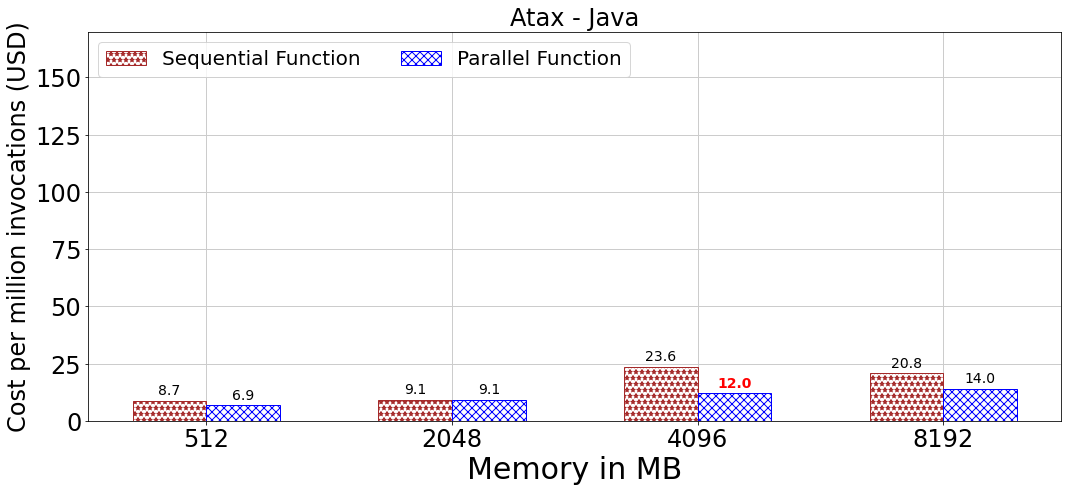

[1590.4  603.1  530.9  554.3]
golang [15.200000000000001, 20.7, 35.199999999999996, 48.0] [15.200000000000001, 20.7, 35.199999999999996, 41.199999999999996]
0.0 0
0.0 0
0.0 0
0.14166666666666675 0


<ipython-input-673-cf7f6db94b64>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mem_values_short)


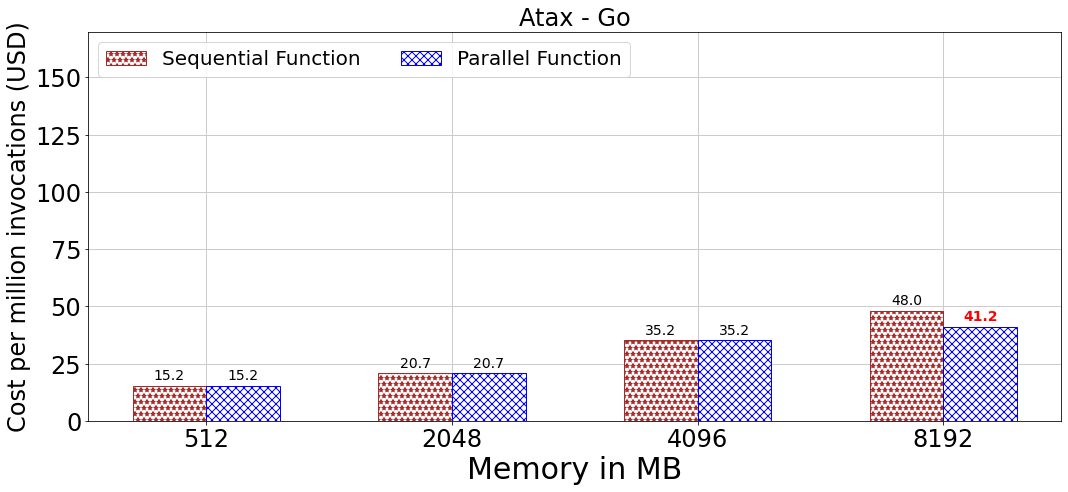

In [673]:
# Cost GCF
for l in languages:
    if (l == 'python' or l == 'c++'):
        continue
    gcf_seq = df_s[(df_s['Service'] == 'google') & (df_s['Language'] == l) & (df_s['Memory'] != 10240)]
    gcf_par = df_m[(df_m['Service'] == 'google') & (df_m['Language'] == l) & (df_m['Memory'] != 10240)]
    gcf_seq = np.asarray(gcf_seq['_value'])
    gcf_par = np.asarray(gcf_par['_value'])
    
    if(func == 'heat' and l == 'java'):
        gcf_seq = np.insert(gcf_seq, 0, 0)
        gcf_par = np.insert(gcf_par, 0, 0)
    print(gcf_par)
    gcf_costs_seq = calculate_costs_gcf(gcf_seq)
    gcf_costs_par = calculate_costs_gcf(gcf_par)
    
    
    print(l, gcf_costs_seq, gcf_costs_par)
    fig, ax = plt.subplots(figsize=(15,7))

    if(func == 'heat' and l == 'java'):
        gcf_costs_seq = np.delete(gcf_costs_seq, 0)
        gcf_costs_par = np.delete(gcf_costs_par, 0)
        x = np.arange(len(heat_mem_values_short))
        ax.set_xticklabels(heat_mem_values_short)
    else:
        x = np.arange(len(mem_values_short))
        ax.set_xticklabels(mem_values_short)

    width = 0.30
    offset = 0.5

    seq_bar = ax.bar(x - width * offset , gcf_costs_seq, width, ecolor='blue', edgecolor='brown', label='Sequential Function', color = 'w', hatch = '**')
    par_bar = ax.bar(x + width * offset , gcf_costs_par, width, ecolor='blue', edgecolor='blue', label='Parallel Function', color = 'w', hatch = 'xxx')

    ax.set_ylabel('Cost per million invocations (USD)', size=24.0)
    ax.set_xlabel('Memory in MB', size=30.0)
    # ax.set_title('Cost Comparison in ' + l)
    ax.set_xticks(x)
    
    ax.legend(prop={'size': 20}, loc='upper left')

    ax.bar_label(seq_bar, padding=3, fmt='%1.1f', size=14)
    # ax.bar_label(par_bar, padding=3, fmt='%1.1f', size=14)
    
    ax.tick_params(axis='both', labelsize = 24.0)
    ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
    diffIndex = indexHighestDiffPercentage(gcf_costs_seq, gcf_costs_par)
    #ax.bar_label(par_bar, padding=3, fmt='%1.2f', size=14)
    autolabel(par_bar, ax, gcf_costs_par[diffIndex], 0)
    ax.legend(prop={'size': 20}, loc='upper left', ncol=3)
    ax.set_ylim([0,170])
    ax.set_axisbelow(True)
    ax.set_title(getFuncLabel(func) + ' - ' + getLangLabel(l), size=24)

    fig.tight_layout()
    fig.savefig("Graphs/Cost_Normal/Cost_" + func + "_" + l + "_GCF.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

    plt.show()
    


[1590.4  603.1  530.9  554.3]
java [15.200000000000001, 20.7, 35.199999999999996, 48.0] [15.200000000000001, 20.7, 35.199999999999996, 41.199999999999996]
0.4424480628860192 0
0.49835526315789475 0.4424480628860192
0.4984326018808778 0.49835526315789475
0.4154727793696274 0.4984326018808778
[89.05000000000001, 121.60000000000001, 127.60000000000001, 139.6] [49.65, 61.0, 64.0, 81.60000000000001]


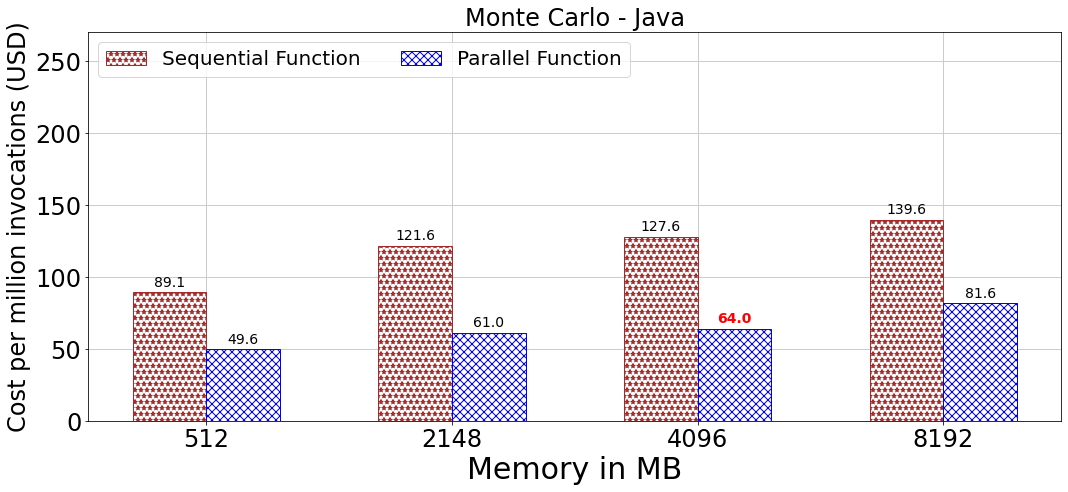

[1590.4  603.1  530.9  554.3]
golang [15.200000000000001, 20.7, 35.199999999999996, 48.0] [15.200000000000001, 20.7, 35.199999999999996, 41.199999999999996]
0.4743558873103781 0
0.6986166007905138 0.4743558873103781
0.6986817325800376 0.6986166007905138
0.6987951807228916 0.6986817325800376
[103.825, 202.4, 212.4, 232.4] [54.574999999999996, 61.0, 64.0, 70.0]


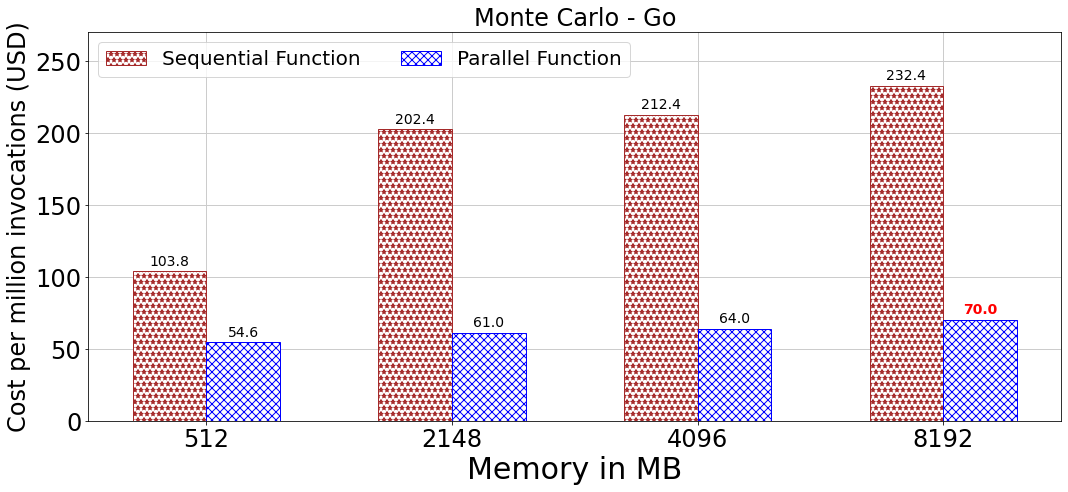

[1590.4  603.1  530.9  554.3]
c++ [15.200000000000001, 20.7, 35.199999999999996, 48.0] [15.200000000000001, 20.7, 35.199999999999996, 41.199999999999996]
0.4404695360536613 0
0.6637458926615554 0.4404695360536613
0.6638830897703549 0.6637458926615554
0.6641221374045803 0.6638830897703549
[44.725, 91.30000000000001, 95.80000000000001, 104.80000000000001] [25.025, 30.7, 32.2, 35.199999999999996]


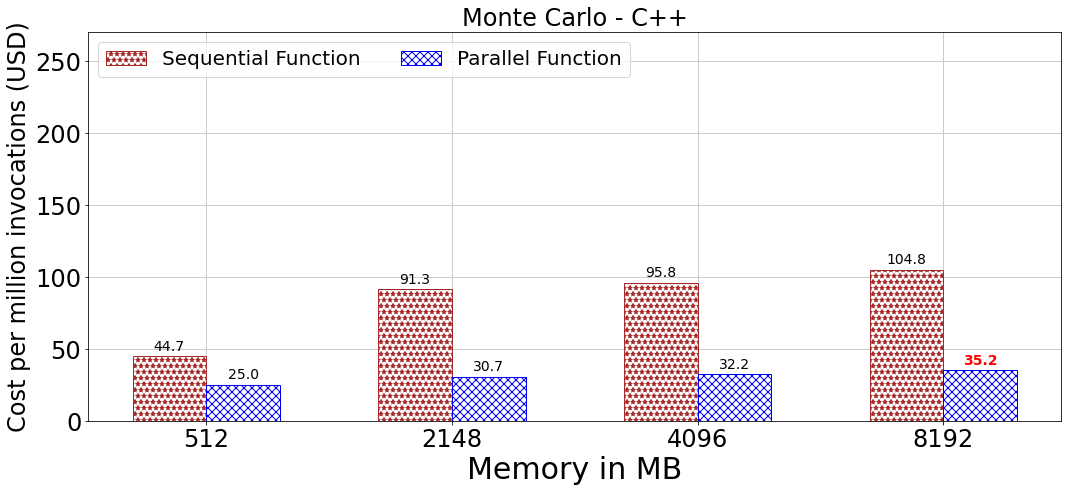

32.899022801302934 69.86166007905138


In [687]:
for l in languages:
    if (l == 'python'):
        continue
    gcr_seq = df_s[(df_s['Service'] == 'gcr') & (df_s['Language'] == l) & (df_s['Memory'] != 10240)]
    gcr_par = df_m[(df_m['Service'] == 'gcr') & (df_m['Language'] == l) & (df_m['Memory'] != 10240)]
    gcr_seq = np.asarray(gcr_seq['_value'])
    gcr_par = np.asarray(gcr_par['_value'])
    

    
    gcr_costs_seq = calculate_costs_gcr(gcr_seq)
    gcr_costs_par = calculate_costs_gcr(gcr_par)
    print(gcf_par)
    print(l, gcf_costs_seq, gcf_costs_par)
    
    diff = gcr_costs_seq[len(gcr_costs_seq) -3] - gcr_costs_par[len(gcr_costs_seq)- 3]
    diff = diff / gcr_costs_seq[len(gcr_costs_seq)- 3]
    diff = diff * 100
    
    if(diff < lowest_diff):
        lowest_diff = diff
        print(lowest_diff)
    if(diff > highest_diff):
        highest_diff = diff
        print(diff)
    
    
    fig, ax = plt.subplots(figsize=(15,7))

    x = np.arange(len(mem_values_short))

    width = 0.30
    offset = 0.5

    seq_bar = ax.bar(x - width * offset , gcr_costs_seq, width, ecolor='blue', edgecolor='brown', label='Sequential Function', color = 'w', hatch = '**')
    par_bar = ax.bar(x + width * offset , gcr_costs_par, width, ecolor='blue', edgecolor='blue', label='Parallel Function', color = 'w', hatch = 'xxx')

    ax.set_ylabel('Cost per million invocations (USD)', size=24.0)
    ax.set_xlabel('Memory in MB', size=30.0)
    # ax.set_title('Cost Comparison in ' + l)
    ax.set_xticks(x)
    ax.set_xticklabels(mem_values_gcr)
    
    ax.legend(prop={'size': 20}, loc='upper left', ncol=2)
    if(l == 'java' and func == 'heat'):
        ax.legend(prop={'size': 20}, loc='upper right', ncol=2)

    ax.bar_label(seq_bar, padding=3, fmt='%1.1f', size=14)
    # ax.bar_label(par_bar, padding=3, fmt='%1.1f', size=14)
    diffIndex = indexHighestDiffPercentage(gcr_costs_seq, gcr_costs_par)
    print(gcr_costs_seq, gcr_costs_par)
    #ax.bar_label(par_bar, padding=3, fmt='%1.2f', size=14)
    autolabel(par_bar, ax, gcr_costs_par[diffIndex], 0)
    
    ax.tick_params(axis='both', labelsize = 24.0)
    ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    ax.set_ylim([0, 270])
    ax.set_title(getFuncLabel(func) + ' - ' + getLangLabel(l), size=24)
    fig.tight_layout()
    fig.savefig("Graphs/Cost_Normal/Cost_" + func + "_" + l + "_GCR.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

    plt.show()
print(lowest_diff, highest_diff) 

aws [659.2 211.8 230.7 210.4 216.1] [903.81818182 286.         194.         184.5        184.2       ] [1317.7  399.8  412.8  385.9  396.4]
aws


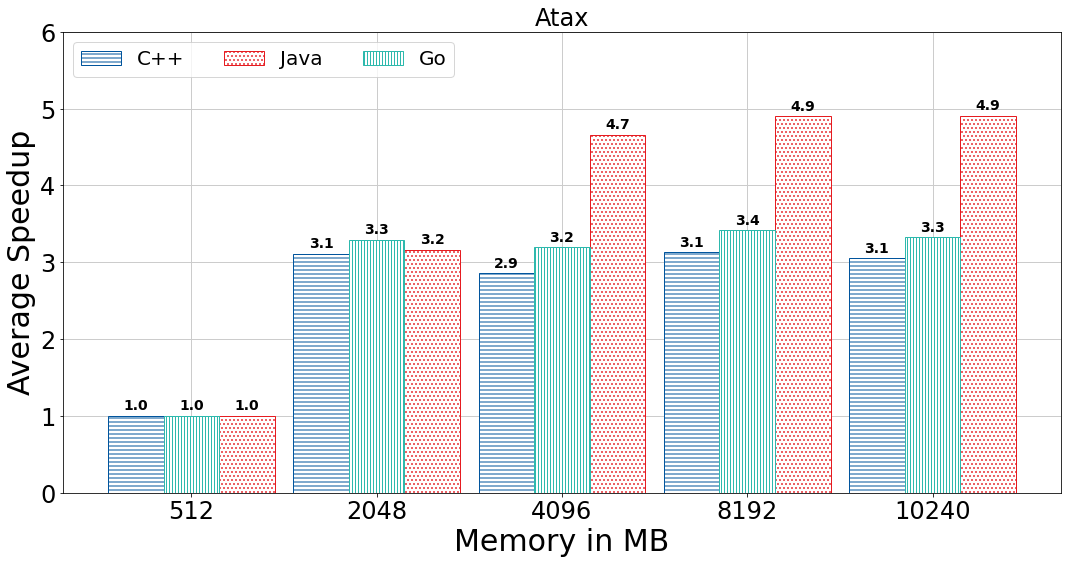

gcr [294.0030604 302.3030899 300.3500932 296.174918 ] [333.928437  199.2736432 233.6130103 228.5220485] [455.5365443 459.6633008 461.5837268 453.7472879]
gcr


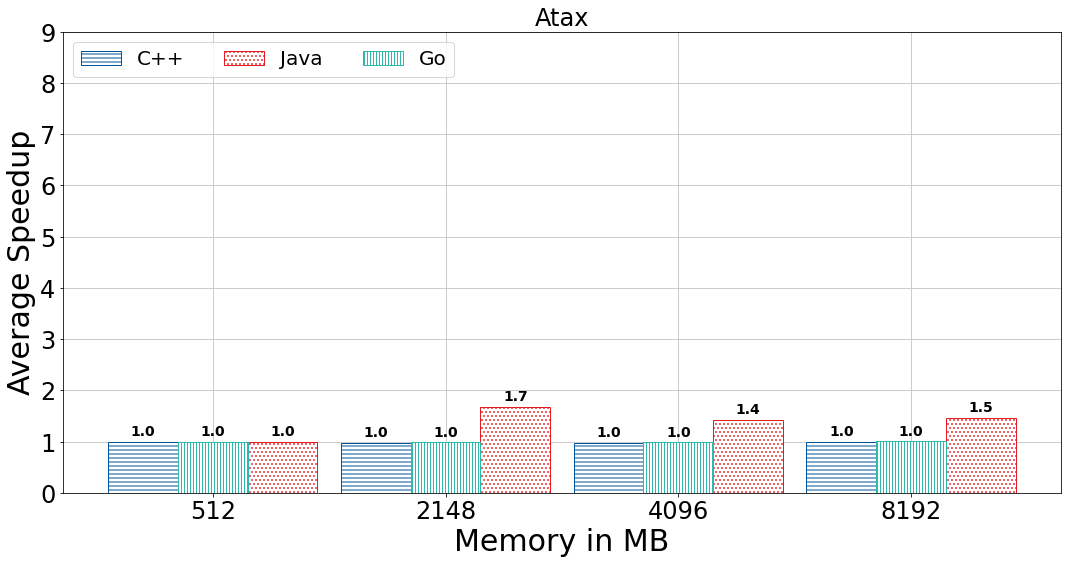

google [] [853.7 268.2 304.8 230.8] [1500.4  664.1  597.4  637.8]
google
google [0 1 2 3] [512, 2048, 4096, 8192] [853.7 268.2 304.8 230.8]


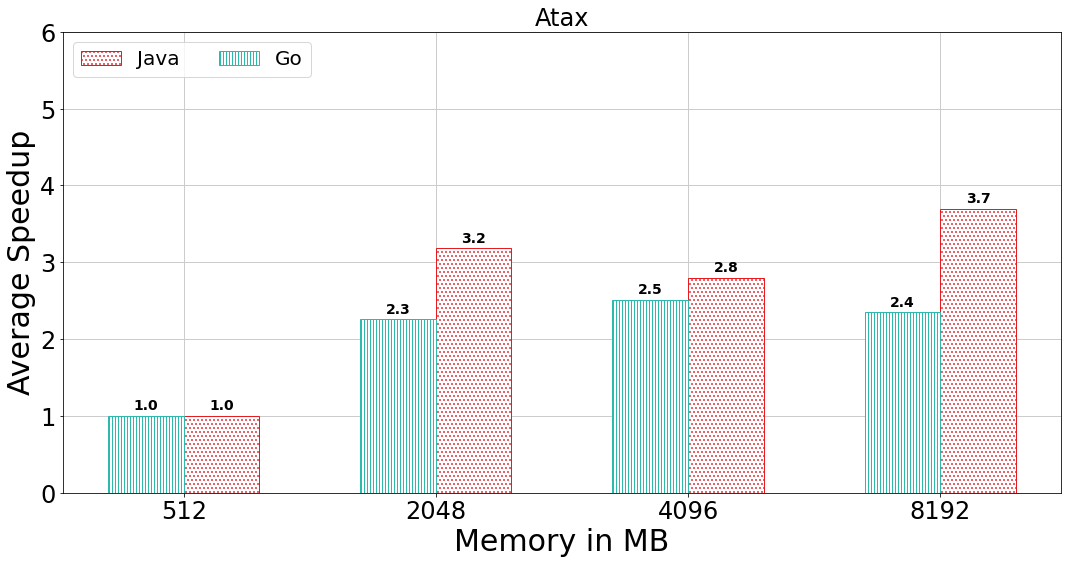

In [702]:
# Sequential Speedups
from matplotlib import rc, rcParams
rc('font', weight='normal')
df_m = df_f_mean[(df_f_mean['Threads'] > 1)]
df_s = df_f_mean[(df_f_mean['Threads'] == 1)]
df_m = df_m.sort_values(by=['Memory'])
df_s = df_s.sort_values(by=['Memory'])
df = df_s
for service in services:
    if(service == 'vm' or service == 'ow'):
        continue
    
    seq_cpp = []
    seq_java = []
    seq_go = []

    function = func
    java_df = df[(df['Service'] == service) & (df['Language'] == 'java')]
    go_df = df[(df['Service'] == service) & (df['Language'] == 'golang')]
    cpp_df = df[(df['Service'] == service) & (df['Language'] == 'c++')]
    cpp_times=np.asarray(cpp_df['_value'])
    java_times=np.asarray(java_df['_value'])
    golang_times=np.asarray(go_df['_value'])
    
    # Have some values for 10GB but theyre actually 8GB -> delete last value
    if service == 'google' or  service == 'gcr':
        if(len(cpp_times) > 4):
            cpp_times = np.delete(cpp_times, 4)
        if(len(java_times) > 4):
            java_times = np.delete(java_times, 4)
        if(len(golang_times) > 4):
            golang_times = np.delete(golang_times, 4)
        
    print(service, cpp_times, java_times, golang_times)
    for i in range (len(golang_times)):
        seq_go.append(golang_times[0] / golang_times[i])
        if func != 'heat' or service == 'gcr':
            seq_java.append(java_times[0] / java_times[i])
        if service != 'google':
            seq_cpp.append(cpp_times[0] / cpp_times[i])

    
    fig, ax = plt.subplots(figsize=(15,8))
    x_1 = np.arange(len(mem_values))
    if(service == 'google' or service == 'gcr'):
        x_1 = x_1 = np.arange(len(mem_values_short))
        
    width = 0.30
    offset = 0.5
    print(service)
    if(service != 'google'):
        offset = 0
        if(func == 'heat' and service == 'aws'):
            offset = 0.5
        cpp_bar = ax.bar(x_1 - width * (1 - offset * (3)), seq_cpp, width, label='C++', ecolor='#01559d', edgecolor='#01559d', color='w', hatch='---')
        ax.bar_label(cpp_bar, padding=3, fmt='%1.1f', size=14, weight='bold')
    if func != 'heat' or service == 'gcr':
        java_bar = ax.bar(x_1 + width * (1 - offset), seq_java, width, label='Java', ecolor='#e61c21', edgecolor='#e61c21', color='w', hatch='...')
        ax.bar_label(java_bar, padding=3, fmt='%1.1f', size=14, weight='bold')
    if(service == 'google' and func == 'heat'):
        offset = 0
    go_bar = ax.bar(x_1 - width * (0 + offset), seq_go, width, label='Go', ecolor='#2eb9ad', edgecolor='#2eb9ad', color='w', hatch='||||')
    
    
    funcLabel = getFuncLabel(func)
    ax.set_title(funcLabel, size = 24)
    
    ax.set_ylabel('Average Speedup', size=30.0)
    ax.set_xlabel('Memory in MB', size=30.0)
    ax.set_xticks(x_1)
    if(service == 'google'):
        print(service, x_2, mem_values_L_short, java_times)
        ax.set_xticklabels(mem_values_short)
    elif(service == 'gcr'):
        ax.set_xticklabels(mem_values_gcr)
    else:
        ax.set_xticklabels(mem_values_L)
    ax.legend(prop={'size': 20}, loc='upper left', ncol=3)

    if(service == 'google'):
        ax.set_ylim([0, 6])
        
    if(service == 'aws'):
        ax.set_ylim([0, 6])
        
    if(service== 'gcr'):
        ax.set_ylim([0, 9])
        
    
    ax.bar_label(go_bar, padding=3, fmt='%1.1f', size=14, weight='bold')
    


    ax.tick_params(axis='both', labelsize = 24.0)
    ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    fig.tight_layout()
    fig.savefig("Graphs/Seq_Speedup/Seq_Speedup_Mean_" + func + "_" + service + ".pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
    plt.show()

aws [2834.1  742.7  386.4  207.4  197.6] [   0.  1081.   585.9  465.3  410.9] [6185.9 1528.3  803.9  437.7  424.7]
aws
(-0.75, 4.75)


<ipython-input-727-00cccf059174>:55: RuntimeWarning: invalid value encountered in double_scalars
  par_java.append(java_times_seq[i] / java_times_par[i])


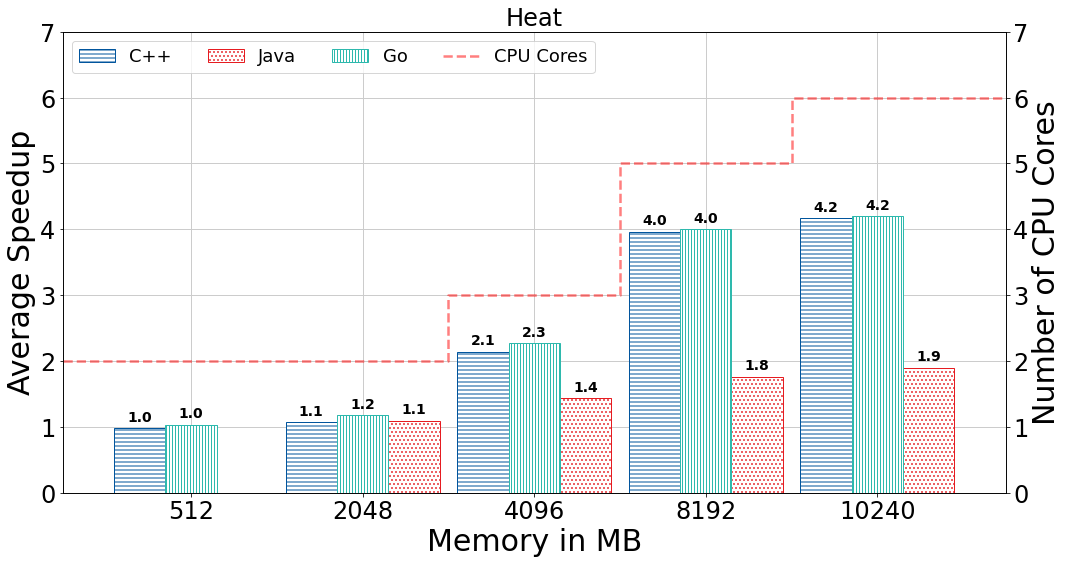

[1075.4448514  649.9720231  660.4745475  584.3097834]
gcr [603.9513046 362.93557   439.7919452 376.4091305] [5894.4234234  370.0587715  361.9036115  346.3402886] [1075.4448514  649.9720231  660.4745475  584.3097834]
gcr
(-0.75, 3.75)


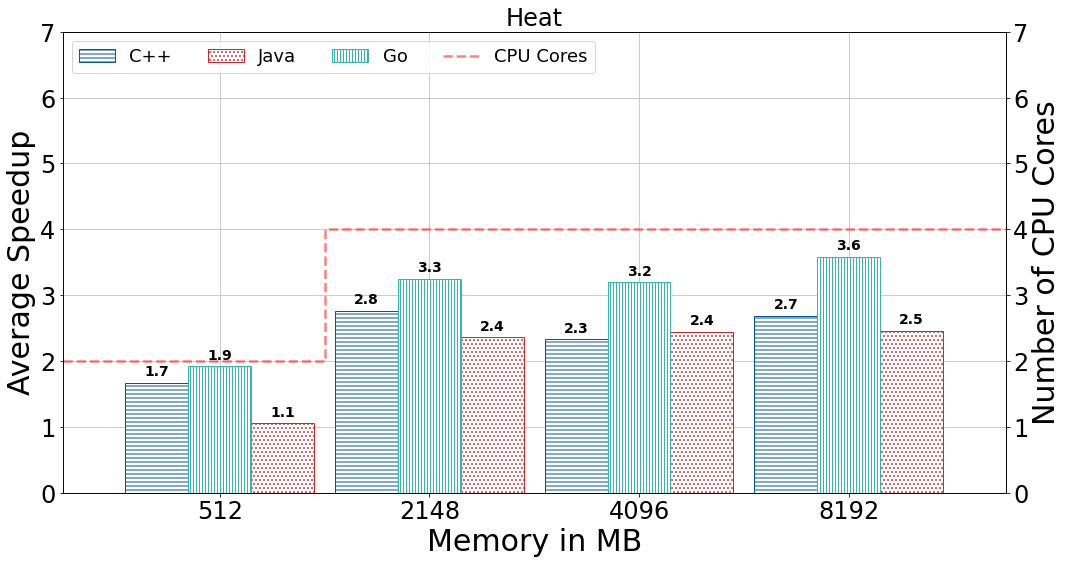

[4564.28571429 2118.4        1538.7        1396.4       ]
google [] [   0.  1278.9  655.8  703.2] [4564.28571429 2118.4        1538.7        1396.4       ]
google
google [0 1 2 3] [512, 2048, 4096, 8192] [853.7 268.2 304.8 230.8]
(-0.75, 3.75)


<ipython-input-727-00cccf059174>:55: RuntimeWarning: invalid value encountered in double_scalars
  par_java.append(java_times_seq[i] / java_times_par[i])


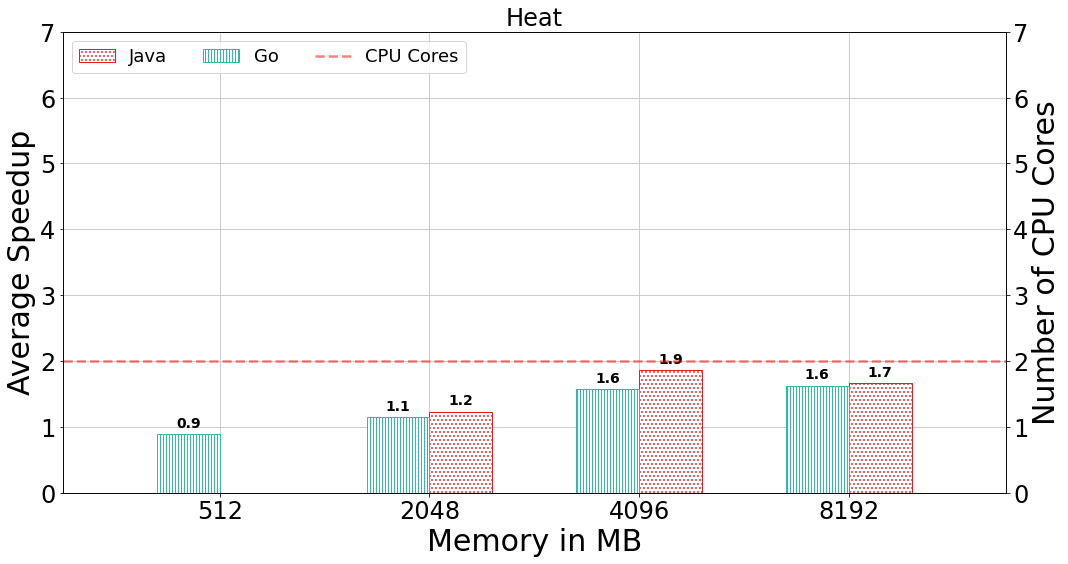

In [727]:
# Speedup Parallel
from matplotlib import rc, rcParams
df_m = df_f_mean[(df_f_mean['Threads'] > 1)]
df_s = df_f_mean[(df_f_mean['Threads'] == 1)]
df_m = df_m.sort_values(by=['Memory'])
df_s = df_s.sort_values(by=['Memory'])
df = df_s
for service in services:
    if(service == 'vm' or service == 'ow'):
        continue
    
    par_cpp = []
    par_java = []
    par_go = []

    function = func
    # seq
    java_df_seq = df_s[(df_s['Service'] == service) & (df_s['Language'] == 'java')]
    go_df_seq = df_s[(df_s['Service'] == service) & (df_s['Language'] == 'golang')]
    cpp_df_seq = df_s[(df_s['Service'] == service) & (df_s['Language'] == 'c++')]
    cpp_times_seq=np.asarray(cpp_df_seq['_value'])
    java_times_seq=np.asarray(java_df_seq['_value'])
    golang_times_seq=np.asarray(go_df_seq['_value'])
    
    java_df_par = df_m[(df_m['Service'] == service) & (df_m['Language'] == 'java')]
    go_df_par = df_m[(df_m['Service'] == service) & (df_m['Language'] == 'golang')]
    cpp_df_par = df_m[(df_m['Service'] == service) & (df_m['Language'] == 'c++')]
    cpp_times_par=np.asarray(cpp_df_par['_value'])
    java_times_par=np.asarray(java_df_par['_value'])
    golang_times_par=np.asarray(go_df_par['_value'])
    
    # Have some values for 10GB but theyre actually 8GB -> delete last value
    if service == 'google' or  service == 'gcr':
        if(len(cpp_times_par) > 4):
            cpp_times_seq = np.delete(cpp_times_seq, 4)
            cpp_times_par = np.delete(cpp_times_par, 4)
        if(len(java_times_par) > 4):
            java_times_seq = np.delete(java_times_seq, 4)
            java_times_par = np.delete(java_times_par, 4)
        print(golang_times_par)
        if(len(golang_times_par) > 4):
            golang_times_seq = np.delete(golang_times_seq, 4)
            golang_times_par = np.delete(golang_times_par, 4)
            
    if(func == 'heat' and service != 'gcr'):
        java_times_seq = np.insert(java_times_seq, 0, 0, axis=0)
        java_times_par = np.insert(java_times_par, 0, 0, axis=0)
            
    
        
    print(service, cpp_times_par, java_times_par, golang_times_par)
    for i in range (len(golang_times_par)):
        par_go.append(golang_times_seq[i] / golang_times_par[i])
        #if (func != 'heat' and i != 0) or service == 'gcr':
        par_java.append(java_times_seq[i] / java_times_par[i])
        if service != 'google':
            par_cpp.append(cpp_times_seq[i] / cpp_times_par[i])

    
    fig, ax = plt.subplots(figsize=(15,8))
    rc('font', weight='normal')
    x_1 = np.arange(len(mem_values))
    if(service == 'google'):
        x_1 = np.arange(len(mem_values_short))
    if(service == 'gcr'):
        x_1 = np.arange(len(mem_values_gcr))
    #    if(func == 'heat'):
    #        x_1 = np.arange(len(heat_mem_values_short))
    #if(func == 'heat'):
    #    x_1 = np.arange(len(heat_mem_values))
    width = 0.30
    offset = 0.5
    print(service)
    if(service != 'google'):
        offset = 0
        cpp_bar = ax.bar(x_1 - width * (1 - offset * (3)), par_cpp, width, label='C++', ecolor='#01559d', edgecolor='#01559d', color='w', hatch='---')
        ax.bar_label(cpp_bar, padding=4, fmt='%1.1f', size=14, weight='bold')
    #if func != 'heat' or service == 'gcr':
    java_bar = ax.bar(x_1 + width * (1 - offset), par_java, width, label='Java', ecolor='#e61c21', edgecolor='#e61c21', color='w', hatch='...')
    ax.bar_label(java_bar, padding=4, fmt='%1.1f', size=14, weight='bold')
    go_bar = ax.bar(x_1 - width * (0 + offset), par_go, width, label='Go', ecolor='#2eb9ad', edgecolor='#2eb9ad', color='w', hatch='||||')

    ax.set_ylabel('Average Speedup', size=30.0)
    ax.set_xlabel('Memory in MB', size=30.0)
    ax.set_xticks(x_1)
    if(service == 'google'):
        print(service, x_2, mem_values_L_short, java_times)
        ax.set_xticklabels(mem_values_short)
    elif(service == 'gcr'):
        ax.set_xticklabels(mem_values_gcr)
    else:
        ax.set_xticklabels(mem_values)
    ax.legend(prop={'size': 20}, loc='upper left', ncol=3)

    if(service == 'gcr'):
        ax.set_ylim([0, 7])
        
    if(service == 'google'):
        ax.set_ylim([0, 7])
        
    if(service == 'aws'):
        ax.set_ylim([0, 7])
        
    funcLabel = getFuncLabel(func)
    ax.set_title(funcLabel, size = 24)

    ax.bar_label(go_bar, padding=4, fmt='%1.1f', size=14, weight='bold')
    
    
    
    # Red line
    ax3 = ax.twinx()
    ax3.set_ylabel('Number of CPU Cores', size=30.0)
    # ax3.set_xlabel('vCPUs', size=30.0)
    ax3.set_ylim([0,7])
    if(service == 'aws'):
        x1, y1 = [-0.75, 0.5, 1.5, 2.5, 3.5, 4.75], [2, 2, 2, 3, 5, 6]
        plt.xlim([-0.75, 4.75])
    if(service == 'google'):
        x1, y1 = [-0.75, 0.5, 1.5, 2.5, 3.75], [2, 2, 2, 2, 2]
        plt.xlim([-0.75, 3.75])
    if(service == 'gcr'):
        x1, y1 = [-0.75, 0.5, 1.5, 2.5, 3.75], [2, 2, 4, 4, 4]
        plt.xlim([-0.75, 3.75])
    ax3.plot(x1, y1, 'r', drawstyle='steps', linestyle='--', alpha=0.5, label='CPU Cores', linewidth=2.5)
    ax3.set_axisbelow(True)
    ax3.tick_params(axis='both', labelsize = 24.0)
    #ax3.spines['left'].set_position('zero')
    #ax3.spines['bottom'].set_position('zero')

    print(ax.get_xlim())
    
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=18.0, ncol=4)
    

    ax.tick_params(axis='both', labelsize = 24.0)
    ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    fig.tight_layout()
    fig.savefig("Graphs/Par_Speedup/Par_Speedup_Mean_" + func + "_" + service + ".pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)
    plt.show()

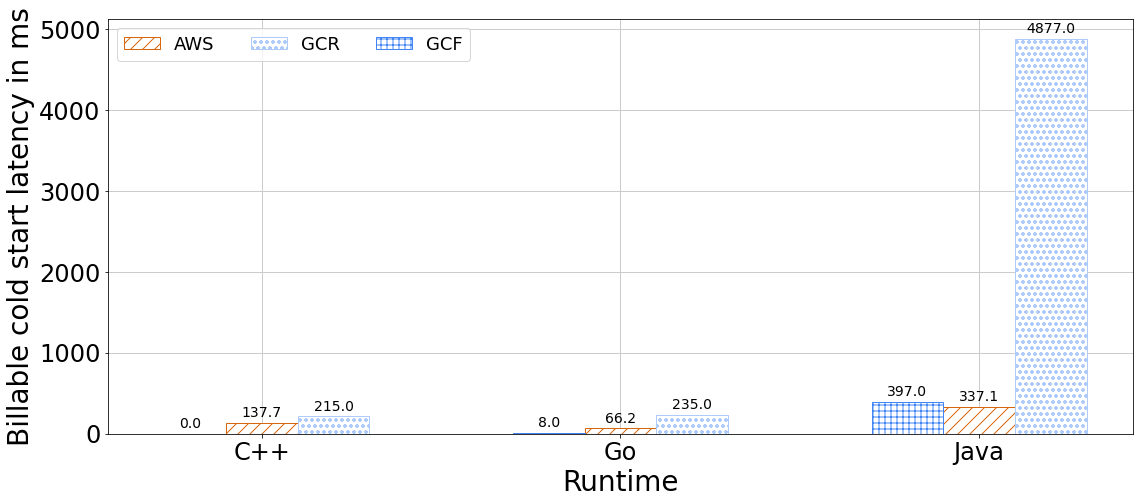

In [302]:
# Cold Starts
aws_cpp = np.median([154.36, 131.13, 137.66, 154.84, 132.89, 135.67, 140.67])
aws_go = np.median([66.25, 59.46, 64.27, 63.51, 75.13, 72.08, 66.49])
aws_java = np.median([318.19, 338.05, 405.91, 362.06, 308.89, 336.06])

gcf_go = np.median([85, 16, 0, 0])
gcf_java = np.median([158, 196, 456, 397, 484, 800, 309])

gcr_cpp = np.median([200, 214, 216, 316])
gcr_go = np.median([310, 235, 375, 235, 232])
gcr_java = np.median([4937, 4710, 5867, 4817])

aws_colds=np.asarray([aws_cpp, aws_go, aws_java])
gcr_colds=np.asarray([gcr_cpp, gcr_go, gcr_java])
gcf_colds=np.asarray([0, gcf_go, gcf_java])
 
fig, ax = plt.subplots(figsize=(16,7))

x = np.arange(len(langs))
        
width = 0.20
offset = 1

aws_bar = ax.bar(x - width * (1 - offset), aws_colds, width, label='AWS', ecolor='#d9660b', edgecolor='#d9660b', color='w', hatch='//')
gcr_bar = ax.bar(x + width * offset, gcr_colds, width, label='GCR', ecolor='#aecbfa', edgecolor='#aecbfa', color='w', hatch='oo')
gcf_bar = ax.bar(x - width * offset, gcf_colds, width, label='GCF', ecolor='#4286f5', edgecolor='#4286f5', color='w', hatch='++')
ax.set_ylabel('Billable cold start latency in ms', size = 28.0)
ax.set_xlabel('Runtime', size = 28.0)
# ax.set_title('Maximum Memory Consumption for MVT',  size = 19.0)
ax.set_xticks(x)
ax.set_xticklabels(langs)
        
ax.bar_label(aws_bar, padding=3, size = 14, fmt='%1.1f')
ax.bar_label(gcr_bar, padding=3, size = 14, fmt='%1.1f')
ax.bar_label(gcf_bar, padding=3, size = 14, fmt='%1.1f')

ax.tick_params(axis='both', labelsize = 24.0)
ax.grid(axis="both", color="0.8", linestyle='-', linewidth=1)
ax.set_axisbelow(True)
ax.legend(prop={'size': 18}, loc='upper left', ncol=3)

fig.tight_layout()
fig.savefig("Graphs/Cold_Starts.pdf",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

plt.show()